In [2]:
import os
import glob
import json
import shutil
import h5py
import sys
import time
from IPython.display import display

import torch

sys.path.insert(0, '..')
from attention_corr_methods import custom_load_attentions

import warnings
warnings.filterwarnings(action='once')

In [36]:
!mkdir ../results/LTH-base/val_attns/
!mkdir ../results/LTH-base/val_attns/encenc/
!mkdir ../results/LTH-base/val_attns/encdec/
!mkdir ../results/LTH-base/val_attns/decdec/

In [26]:
# Set arguments to load reps
limit = 10000
model_count = 9
lth_iters = range(model_count)
reps_dir = '/raj-learn/data/precomputed_attns'
encenc_attn_fname_l = sorted(glob.glob(f'{reps_dir}/LTH*/encenc*.hdf5'))
encdec_attn_fname_l = sorted(glob.glob(f'{reps_dir}/LTH*/encdec*.hdf5'))
decdec_attn_fname_l = sorted(glob.glob(f'{reps_dir}/LTH*/decdec*.hdf5'))
device = 'cuda'

In [49]:
%%time
encenc_num_heads_d, encenc_attns_d = custom_load_attentions(encenc_attn_fname_l,
                                                     limit=limit)
encdec_num_heads_d, encdec_attns_d = custom_load_attentions(encdec_attn_fname_l,
                                                     limit=limit)
decdec_num_heads_d, decdec_attns_d = custom_load_attentions(decdec_attn_fname_l,
                                                     limit=limit)

load: 9it [00:12,  1.33s/it]
load: 9it [00:10,  1.21s/it]
load: 9it [00:11,  1.30s/it]

CPU times: user 27.2 s, sys: 4.99 s, total: 32.2 s
Wall time: 34.5 s


In [164]:
%%time
import attention_corr_methods
import importlib
importlib.reload(attention_corr_methods)
from attention_corr_methods import PearsonMaxCorr, PearsonMaxCorr2, JSMaxCorr, AttnLinCKA, AttnCCA

attns = [(encenc_num_heads_d, encenc_attns_d), 
         (encdec_num_heads_d, encdec_attns_d), 
         (decdec_num_heads_d, decdec_attns_d)]
attntypes = ['encenc', 'encdec', 'decdec']
for (i, attntype) in enumerate(attntypes):
    if attntype != 'decdec':
        continue
    output_dir = f'../results/LTH-base/val_attns/{attntype}/'
#     pearsonmaxcorr = PearsonMaxCorr(attns[i][0], attns[i][1], device)
#     pearsonmaxcorr2 = PearsonMaxCorr2(attns[i][0], attns[i][1], device)
#     jsmaxcorr = JSMaxCorr(attns[i][0], attns[i][1], device)
    lincka = AttnLinCKA(attns[i][0], attns[i][1], device)
#     cca = AttnCCA(num_heads_d, attns[i].copy(), device)
#     for corr_method in [pearsonmaxcorr, pearsonmaxcorr2, jsmaxcorr, lincka]:
    for corr_method in [lincka]:
        t0 = time.time()
        corr_method.compute_correlations()
        corr_method.write_correlations(output_dir + str(corr_method))
        print('%s, %s took %.2fsec' % (str(corr_method), attntype, time.time() - t0))

../aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
lincka: 100%|██████████| 2916/2916 [00:00<00:00, 5020.64it/s]


attn_lincka, decdec took 0.81sec
CPU times: user 3min 13s, sys: 1.75 s, total: 3min 15s
Wall time: 25.8 s


In [56]:
!ls ../results/LTH-base/val_attns/encenc

attn_lincka  jsmaxcorr	pearsonmaxcorr	pearsonmaxcorr2


In [165]:
%%time
import pickle

results_dir = '../results/LTH-base/val_attns'
res_dict = {'encenc' : {}, 'encdec' : {}, 'decdec' : {}}
for attntype in res_dict.keys():
    res_fname = {method: f'{results_dir}/{attntype}/{method}' for method in 
                ["pearsonmaxcorr", "pearsonmaxcorr2", "jsmaxcorr", "attn_lincka"]}
    res_dict[attntype]["pearsonmaxcorr"] = pickle.load(open(res_fname["pearsonmaxcorr"], "rb"))
    res_dict[attntype]["pearsonmaxcorr2"] = pickle.load(open(res_fname["pearsonmaxcorr2"], "rb"))
    res_dict[attntype]["jsmaxcorr"] = pickle.load(open(res_fname["jsmaxcorr"], "rb"))
    res_dict[attntype]["lincka"] = pickle.load(open(res_fname["attn_lincka"], "rb"))

/raj-learn/lth/lib/python3.6/site-packages/ipykernel_launcher.py:8: ResourceWarning: unclosed file <_io.BufferedReader name='../results/LTH-base/val_attns/encenc/pearsonmaxcorr'>
  
/raj-learn/lth/lib/python3.6/site-packages/ipykernel_launcher.py:9: ResourceWarning: unclosed file <_io.BufferedReader name='../results/LTH-base/val_attns/encenc/pearsonmaxcorr2'>
  if __name__ == '__main__':
/raj-learn/lth/lib/python3.6/site-packages/ipykernel_launcher.py:10: ResourceWarning: unclosed file <_io.BufferedReader name='../results/LTH-base/val_attns/encenc/jsmaxcorr'>
  # Remove the CWD from sys.path while we load stuff.
/raj-learn/lth/lib/python3.6/site-packages/ipykernel_launcher.py:11: ResourceWarning: unclosed file <_io.BufferedReader name='../results/LTH-base/val_attns/encenc/attn_lincka'>
  # This is added back by InteractiveShellApp.init_path()
/raj-learn/lth/lib/python3.6/site-packages/ipykernel_launcher.py:8: ResourceWarning: unclosed file <_io.BufferedReader name='../results/LTH-base/

CPU times: user 662 ms, sys: 31.8 ms, total: 694 ms
Wall time: 959 ms


/raj-learn/lth/lib/python3.6/site-packages/ipykernel_launcher.py:11: ResourceWarning: unclosed file <_io.BufferedReader name='../results/LTH-base/val_attns/decdec/attn_lincka'>
  # This is added back by InteractiveShellApp.init_path()


In [183]:
import numpy as np

num_heads = 16
matched_heads = {attntype : {layer : [num_heads] for layer in layers} for attntype in res_dict}

layers = list(range(6))
for attntype in matched_heads:
    for layer in layers:
        pairs = res_dict[attntype]['pearsonmaxcorr']['pairs'][f'LTH0-{attntype}_attns_wmt_en_de_val.hdf5_{layer}']
        for lth_iter in range(1, model_count):
            name = f'LTH{lth_iter}-{attntype}_attns_wmt_en_de_val.hdf5_{layer}'
            matches = (np.arange(num_heads) == pairs[name])
            matched_heads[attntype][layer].append(matches.sum())
        
display(matched_heads)

{'encenc': {0: [16, 15, 13, 11, 10, 9, 9, 7, 7],
  1: [16, 16, 16, 16, 16, 16, 15, 13, 13],
  2: [16, 16, 16, 16, 16, 16, 15, 13, 13],
  3: [16, 16, 16, 16, 16, 15, 14, 14, 13],
  4: [16, 16, 16, 16, 16, 16, 16, 16, 16],
  5: [16, 16, 16, 16, 16, 16, 16, 16, 16]},
 'encdec': {0: [16, 16, 16, 16, 16, 16, 16, 16, 16],
  1: [16, 16, 16, 16, 16, 16, 16, 16, 16],
  2: [16, 16, 16, 16, 16, 16, 16, 16, 16],
  3: [16, 16, 16, 16, 16, 16, 16, 16, 16],
  4: [16, 16, 16, 16, 16, 16, 16, 16, 16],
  5: [16, 16, 16, 16, 16, 16, 16, 16, 16]},
 'decdec': {0: [16, 16, 16, 16, 16, 16, 16, 16, 15],
  1: [16, 16, 16, 16, 16, 16, 16, 16, 16],
  2: [16, 16, 16, 16, 16, 16, 16, 16, 16],
  3: [16, 16, 16, 16, 16, 16, 16, 16, 16],
  4: [16, 16, 16, 16, 16, 16, 16, 16, 15],
  5: [16, 16, 16, 16, 16, 16, 16, 16, 16]}}

In [166]:
def fix_layername(layer):
    return layer.split('_')[0] + '-layer' + str(int(layer.split('_')[-1])+1)

attnsim = {attntype : {key : {} for key in res_dict[attntype]} for attntype in res_dict}
for attntype in attnsim:
    for simtype in attnsim[attntype]:
        layer_names = list(res_dict[attntype]['pearsonmaxcorr']['similarities'].keys())
        for layer in layer_names:
            attnsim[attntype][simtype][fix_layername(layer)] = {fix_layername(layer) : 1.0}
            similarities = res_dict[attntype][simtype]['similarities'][layer]
            for other_layer in similarities:
                attnsim[attntype][simtype][fix_layername(layer)][fix_layername(other_layer)] = similarities[other_layer]

How many of the heads (of each attention type) in each layer are doing the same thing over the course of pruning? i.e. are most correlated to the head in subsequent layers with the same index

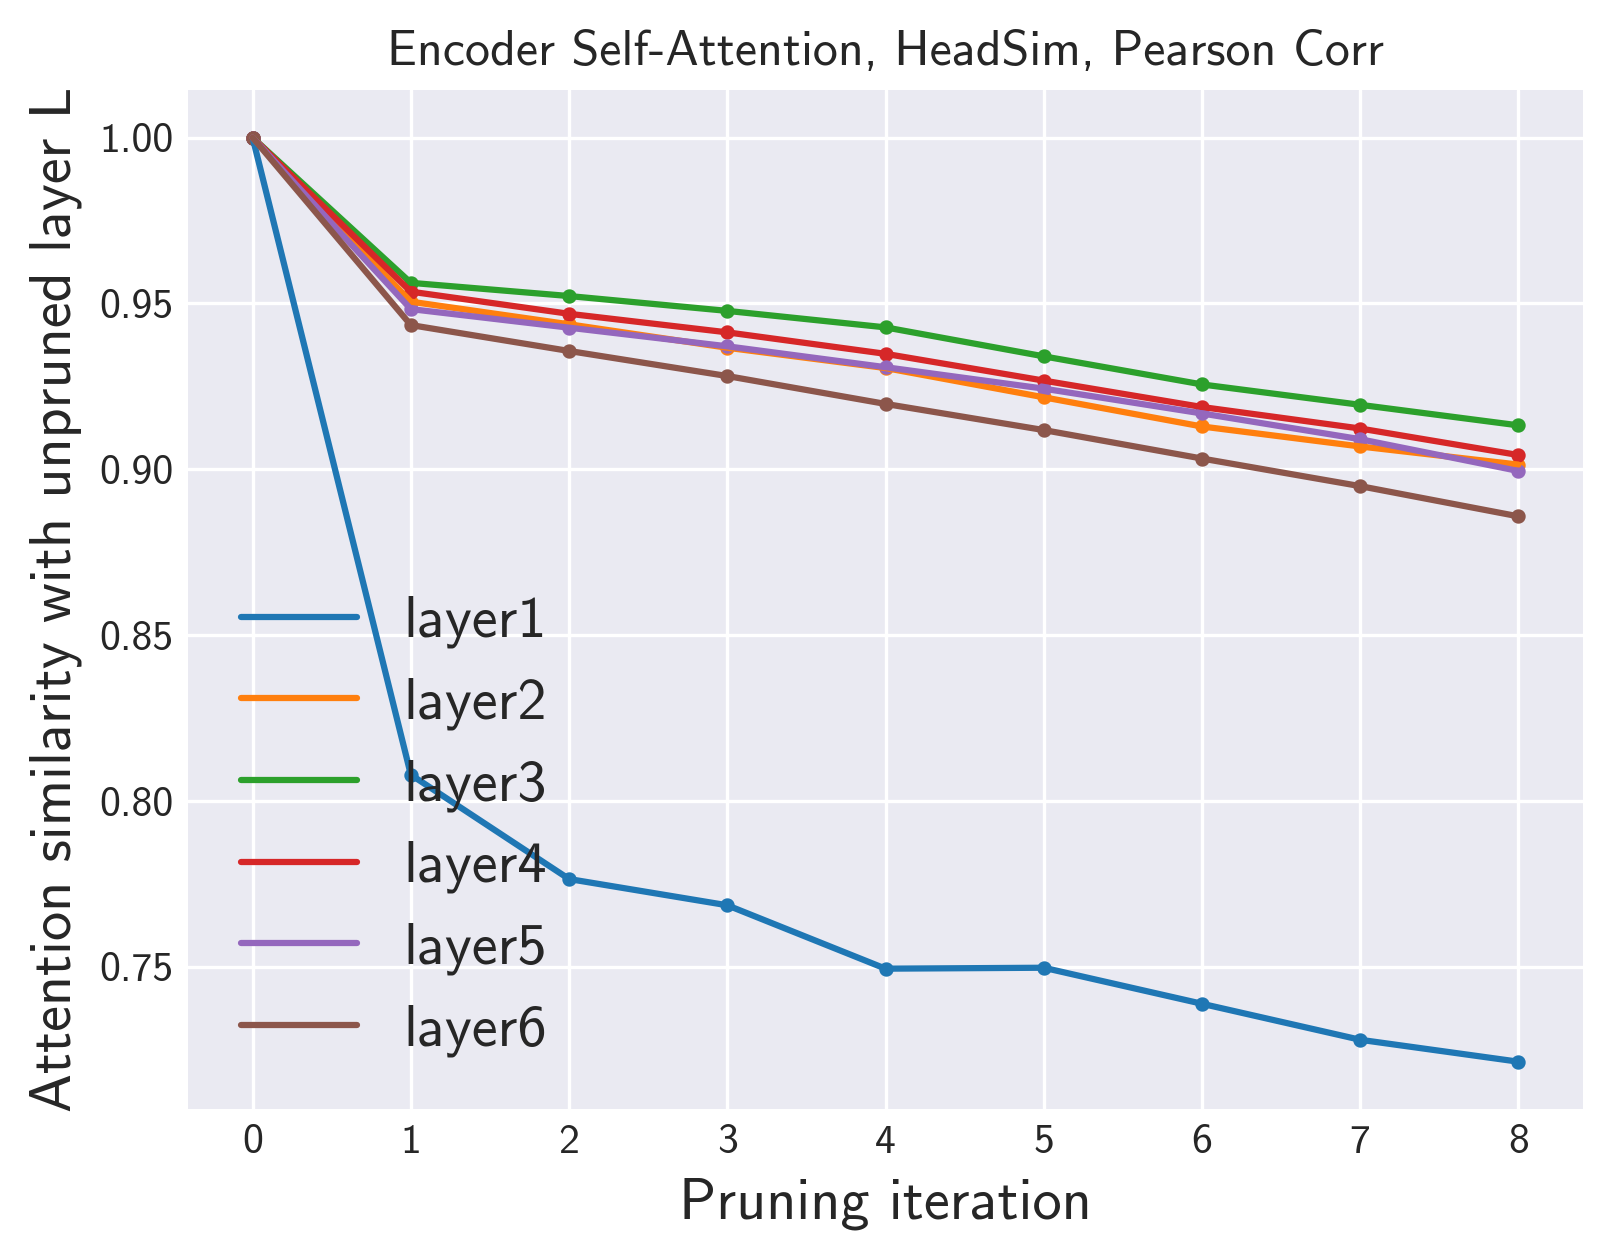

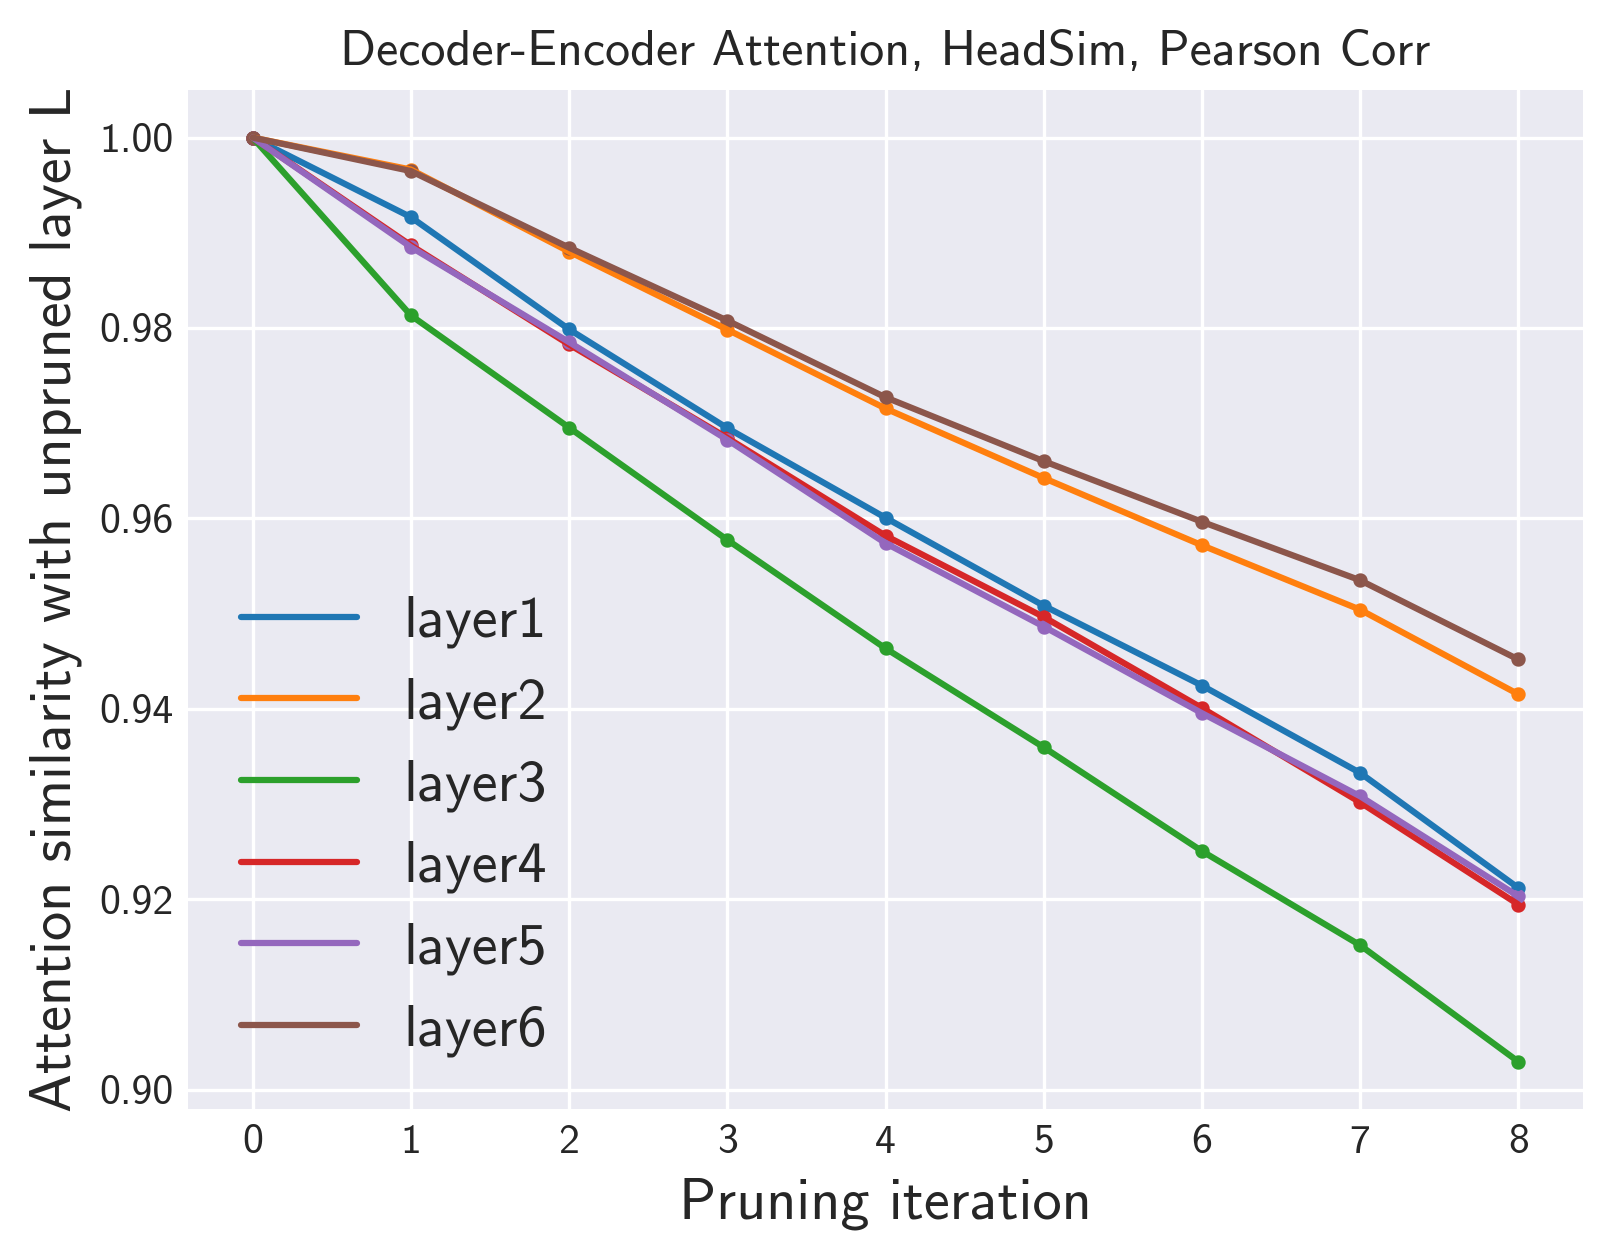

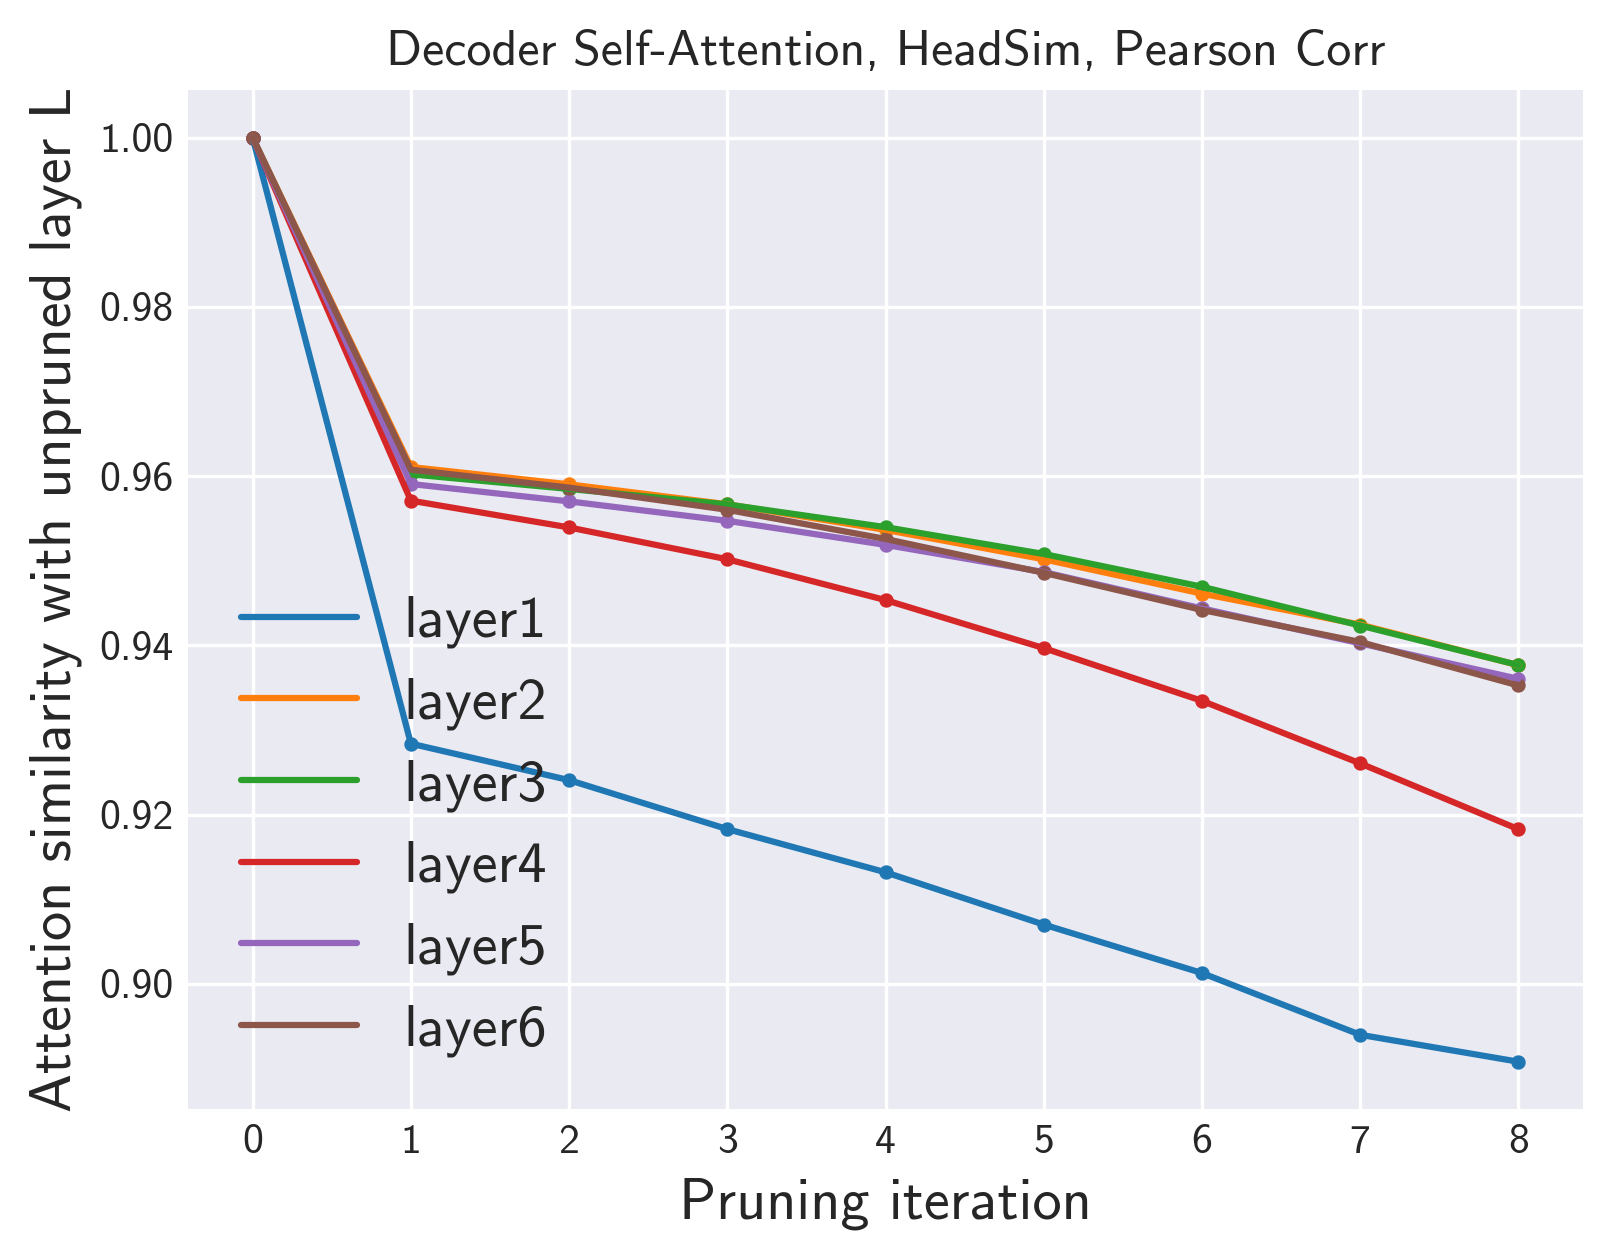

In [170]:
for attntype in attnsim:
    layer_corrs_with_unpruned = {layer : [] for layer in ['layer' + str(i) for i in range(1, 7)]}
    for layer in layer_corrs_with_unpruned:
        cur_layer = f'LTH0-{attntype}-{layer}'
        for lth_iter in range(9):
            layer_corrs_with_unpruned[layer].append(attnsim[attntype]['pearsonmaxcorr'][cur_layer][f'LTH{lth_iter}-{attntype}-{layer}'])

    plt.figure(figsize = (6, 4.5), dpi=300)
    ax = plt.gca()
    x = range(model_count)

    for layer in layer_corrs_with_unpruned:
        ax.plot(x, layer_corrs_with_unpruned[layer], label=layer)
        ax.scatter(x, layer_corrs_with_unpruned[layer], s=6)

    plt.xlabel('Pruning iteration', fontsize=14)
    plt.ylabel('Attention similarity with unpruned layer L', fontsize=14)
    plt.title(f"{type_to_titles[attntype]}, HeadSim, Pearson Corr")
#     plt.title(f"{type_to_titles[attntype]}, LayerSim, LinCKA")
    plt.legend(fontsize=14)
    plt.show()

### Plot

In [150]:
%%time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Rectangle
from matplotlib import rcParams
from matplotlib import font_manager
plt.style.use('seaborn-darkgrid')
fpath = '/raj-learn/envs/contextual_repr_analysis/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf'
prop = font_manager.FontProperties(fname=fpath)
rcParams['font.family'] = prop.get_name()
rcParams['mathtext.fontset'] = 'cm'
rcParams['axes.unicode_minus'] = False

CPU times: user 484 µs, sys: 0 ns, total: 484 µs
Wall time: 501 µs


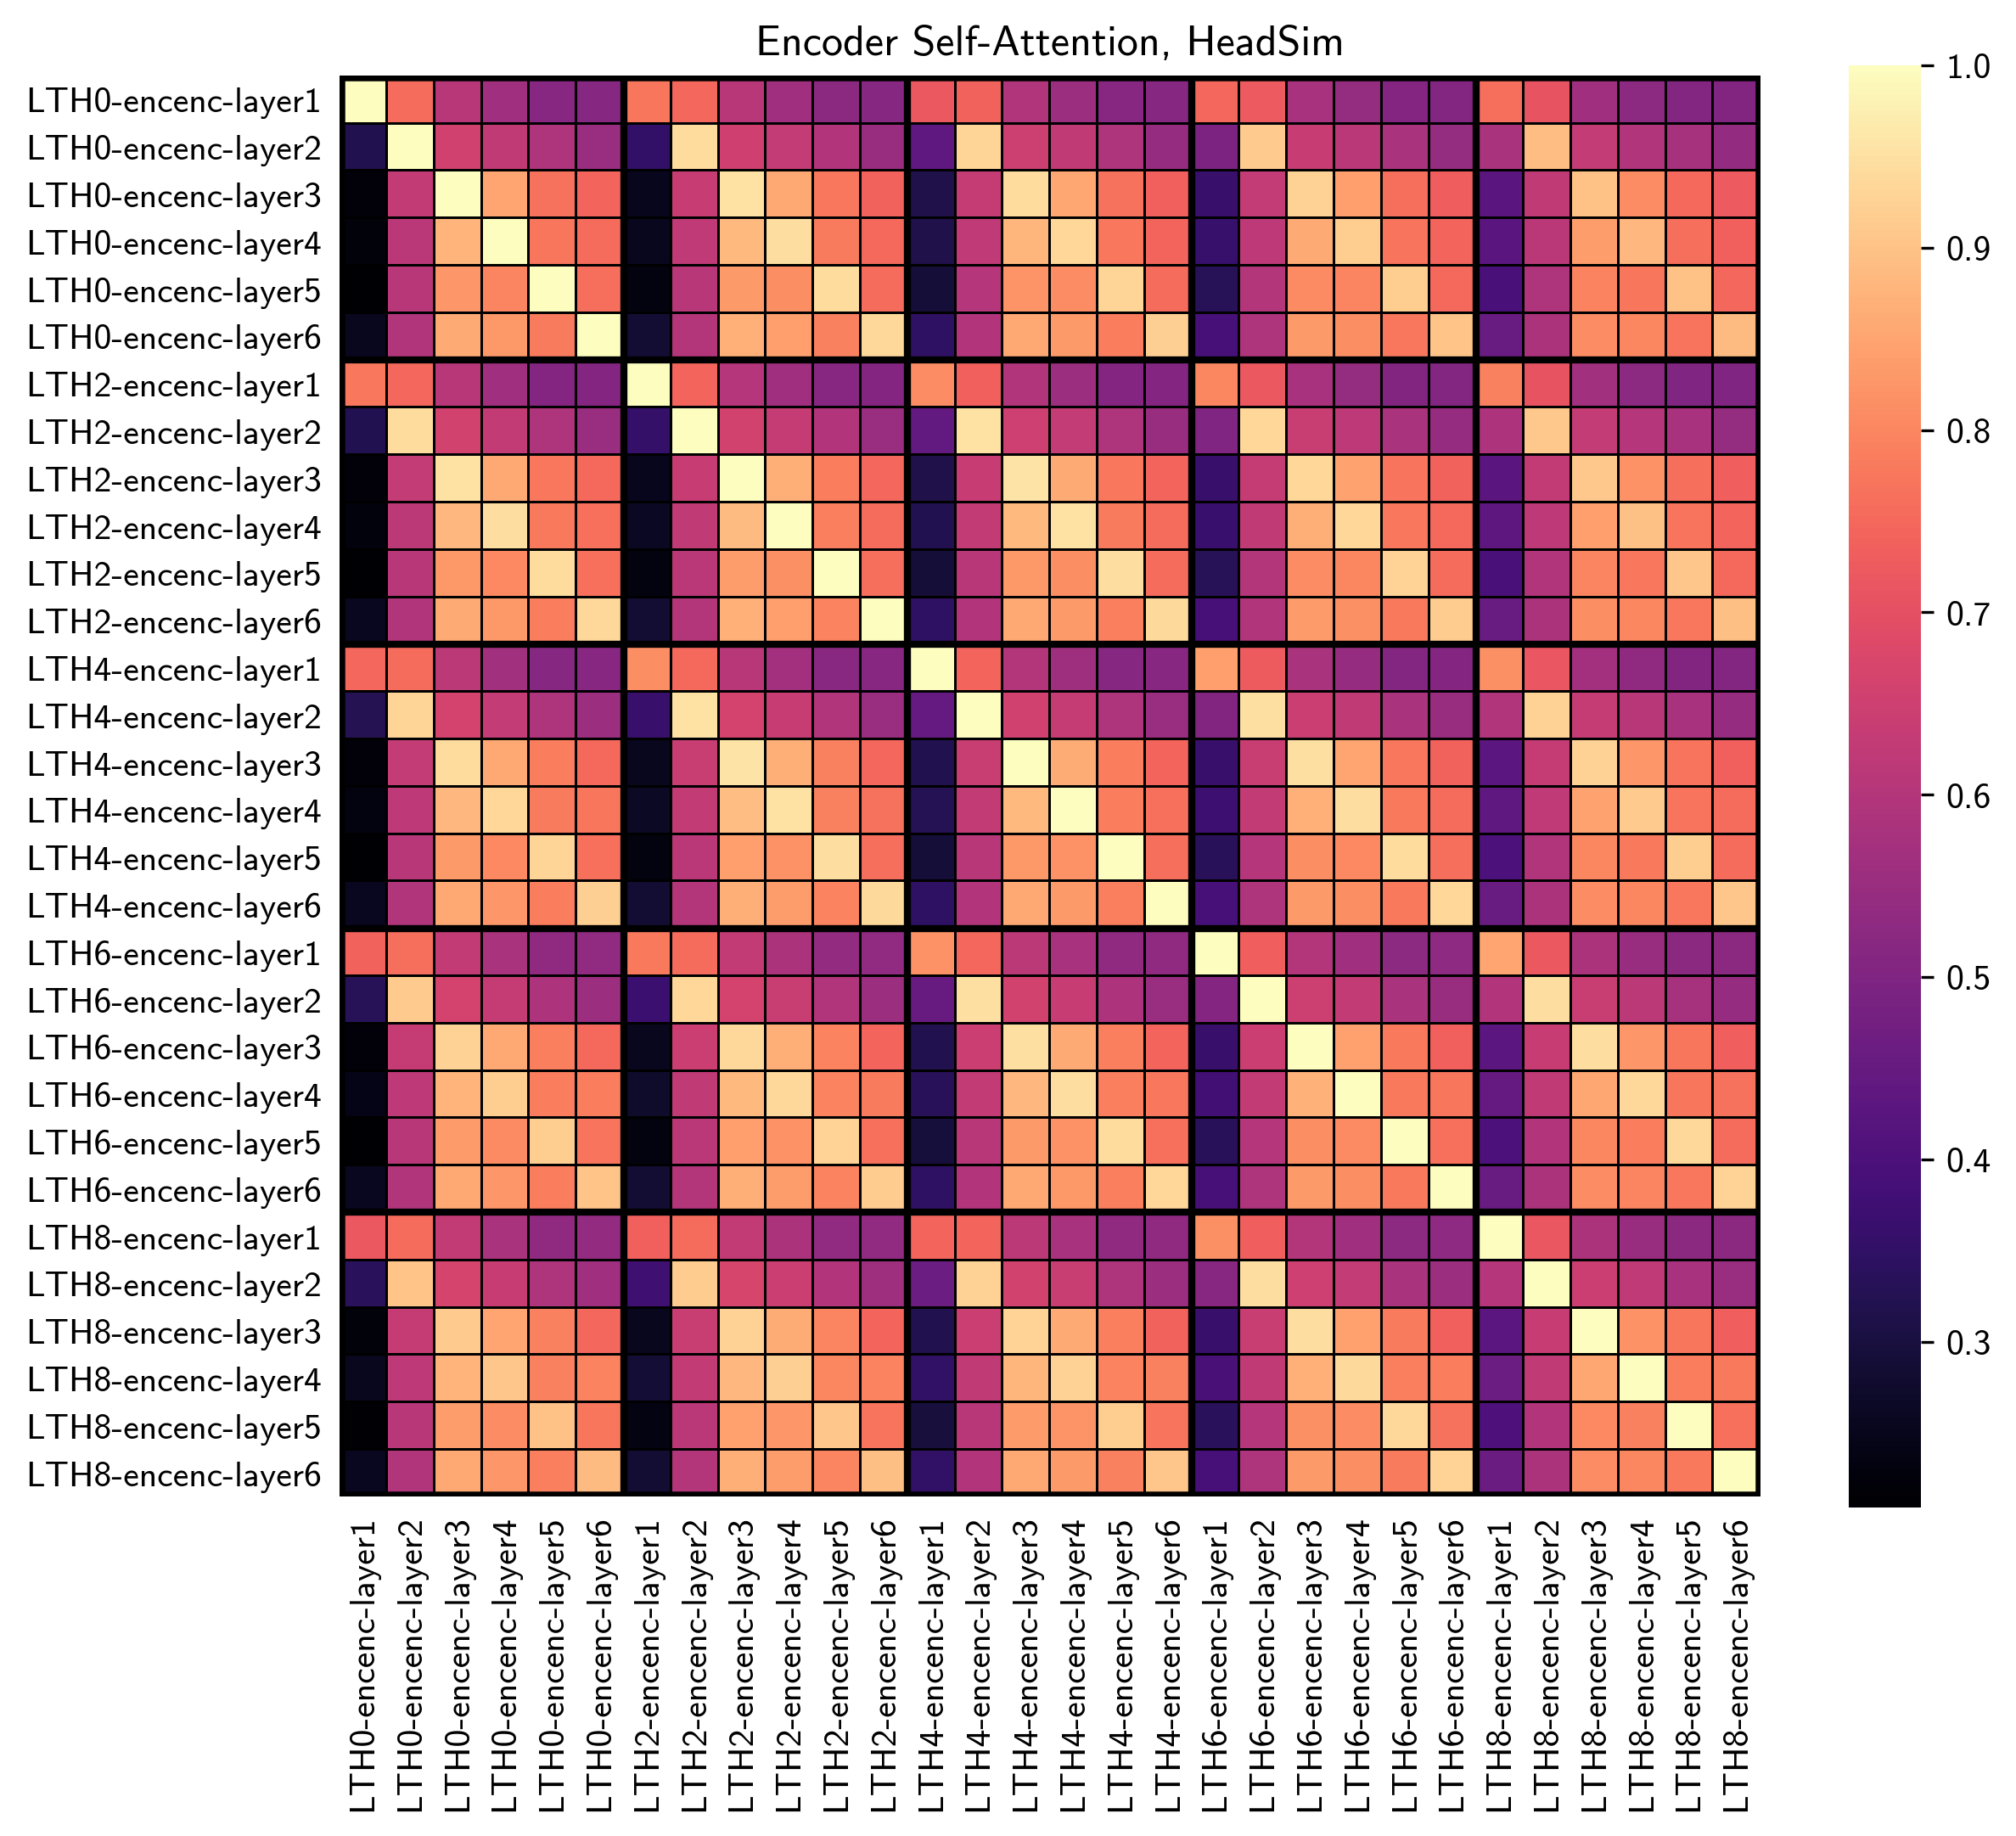

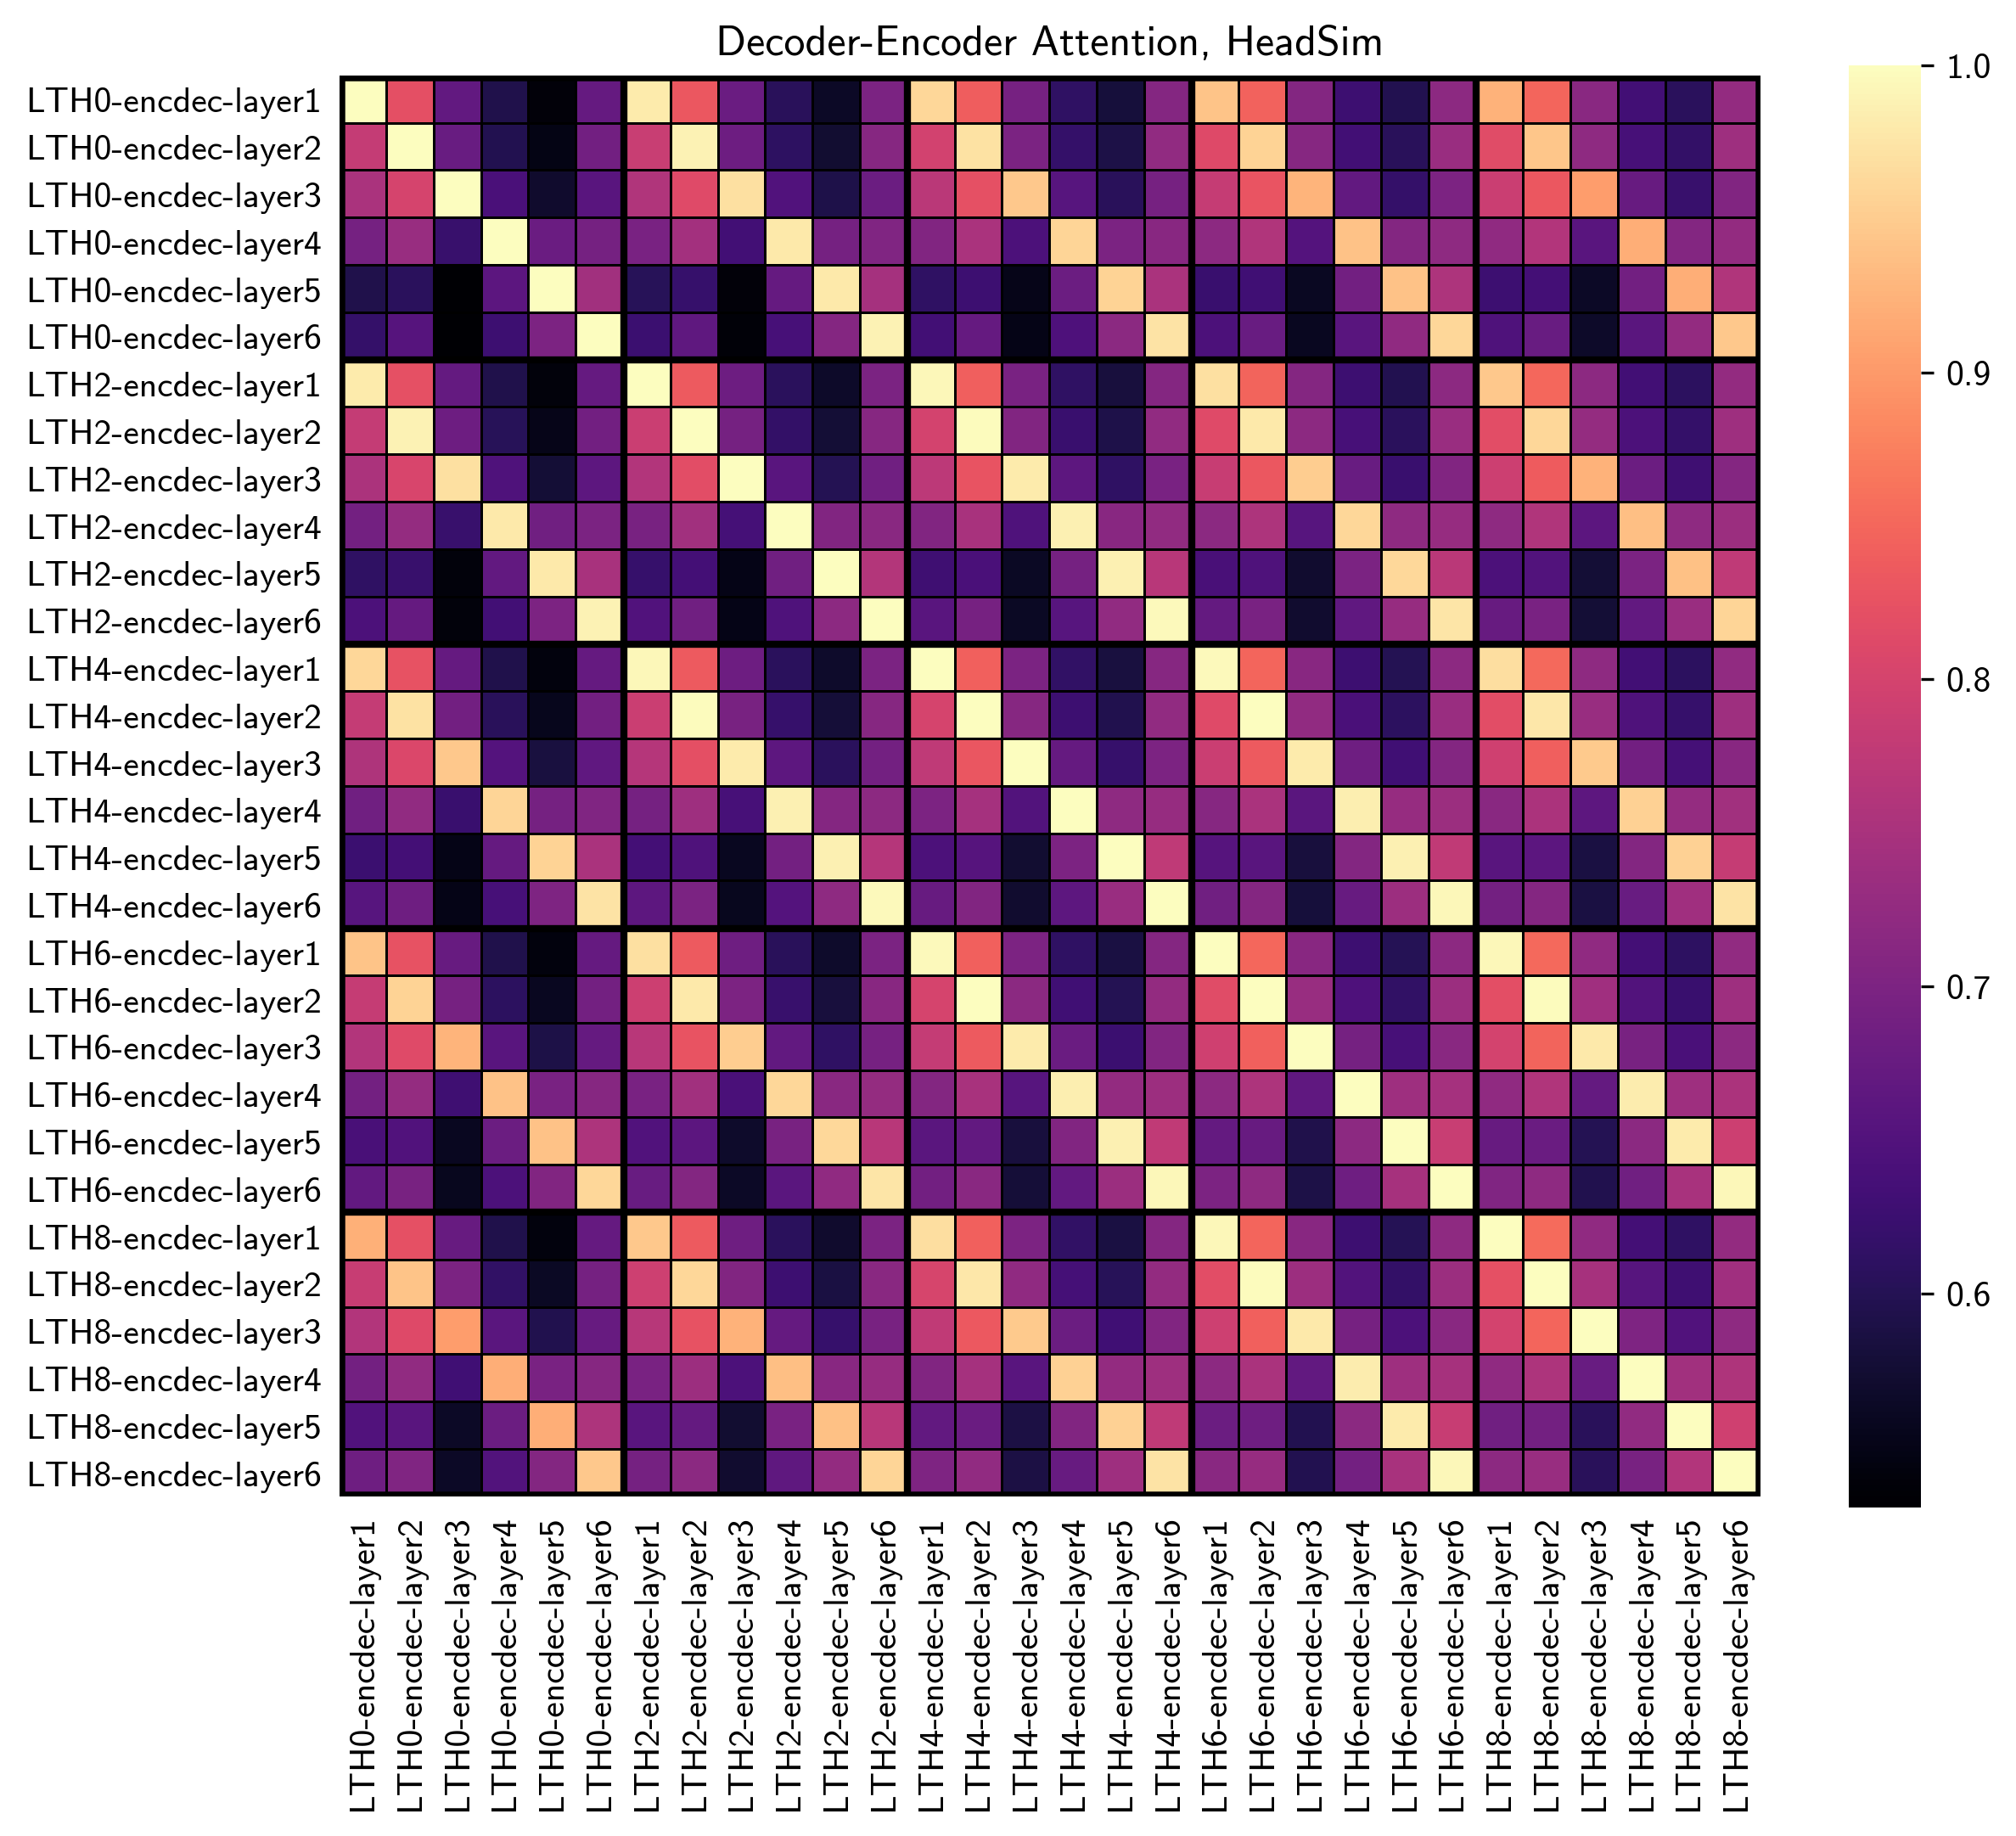

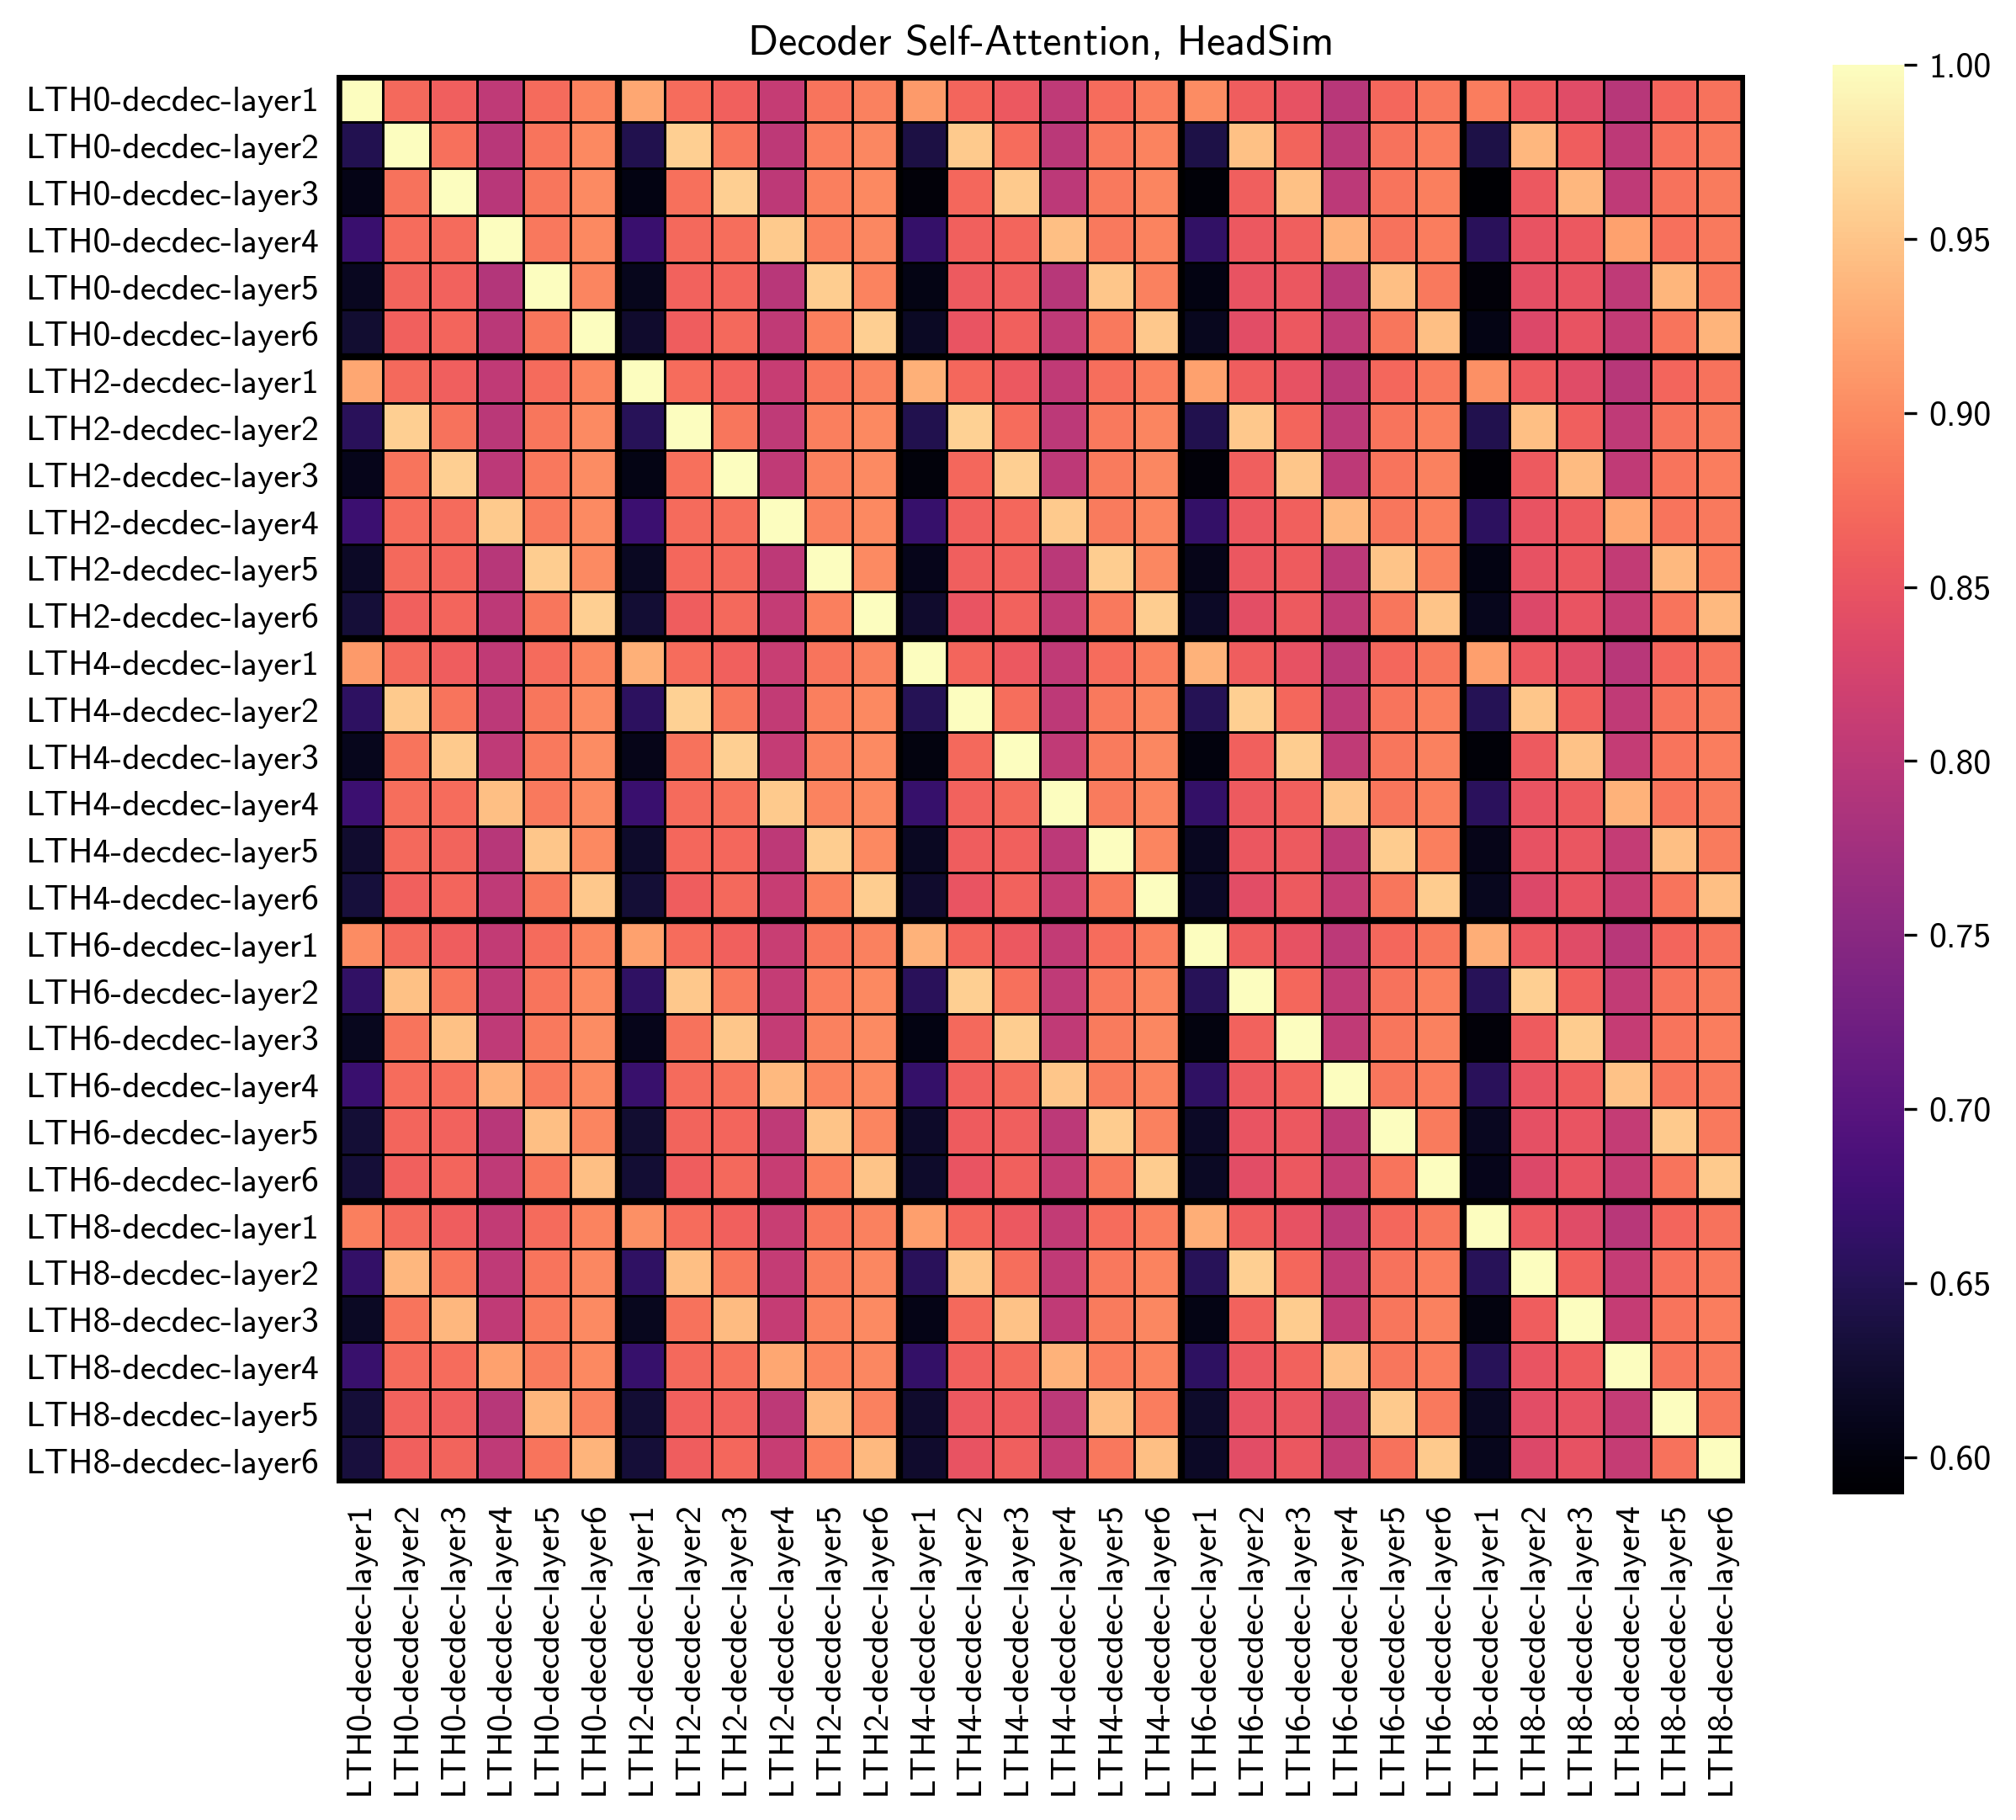

In [132]:
type_to_titles = {'encenc': 'Encoder Self-Attention', 
                  'encdec': 'Decoder-Encoder Attention',
                  'decdec': 'Decoder Self-Attention'
                 }

for attntype in attnsim:
    corr_df = pd.DataFrame(attnsim[attntype]['pearsonmaxcorr'])
    use_models = ['LTH0', 'LTH2', 'LTH4', 'LTH6', 'LTH8']
    use_cols = [col.split('-')[0] in use_models for col in  corr_df.columns]
    corr_df = corr_df.iloc[use_cols, use_cols]

    plt.figure(figsize = (9, 7.5), dpi=300)
    ax = sns.heatmap(corr_df, cmap='magma', lw=0.5, linecolor='k', square=True)
    ax.tick_params(axis='both', which='both', length=0, pad=5)
    for x in range(0, len(corr_df.columns)+6, 6):
        ax.axvline(x, lw=2, color='k')
        ax.axhline(x, lw=2, color='k')
    ax.add_patch(Rectangle((0, 0), len(corr_df.columns), len(corr_df.index), fill=False, edgecolor='black', lw=3))
    ax.set_title(f"{type_to_titles[attntype]}, HeadSim, Pearson Corr")
    plt.show()

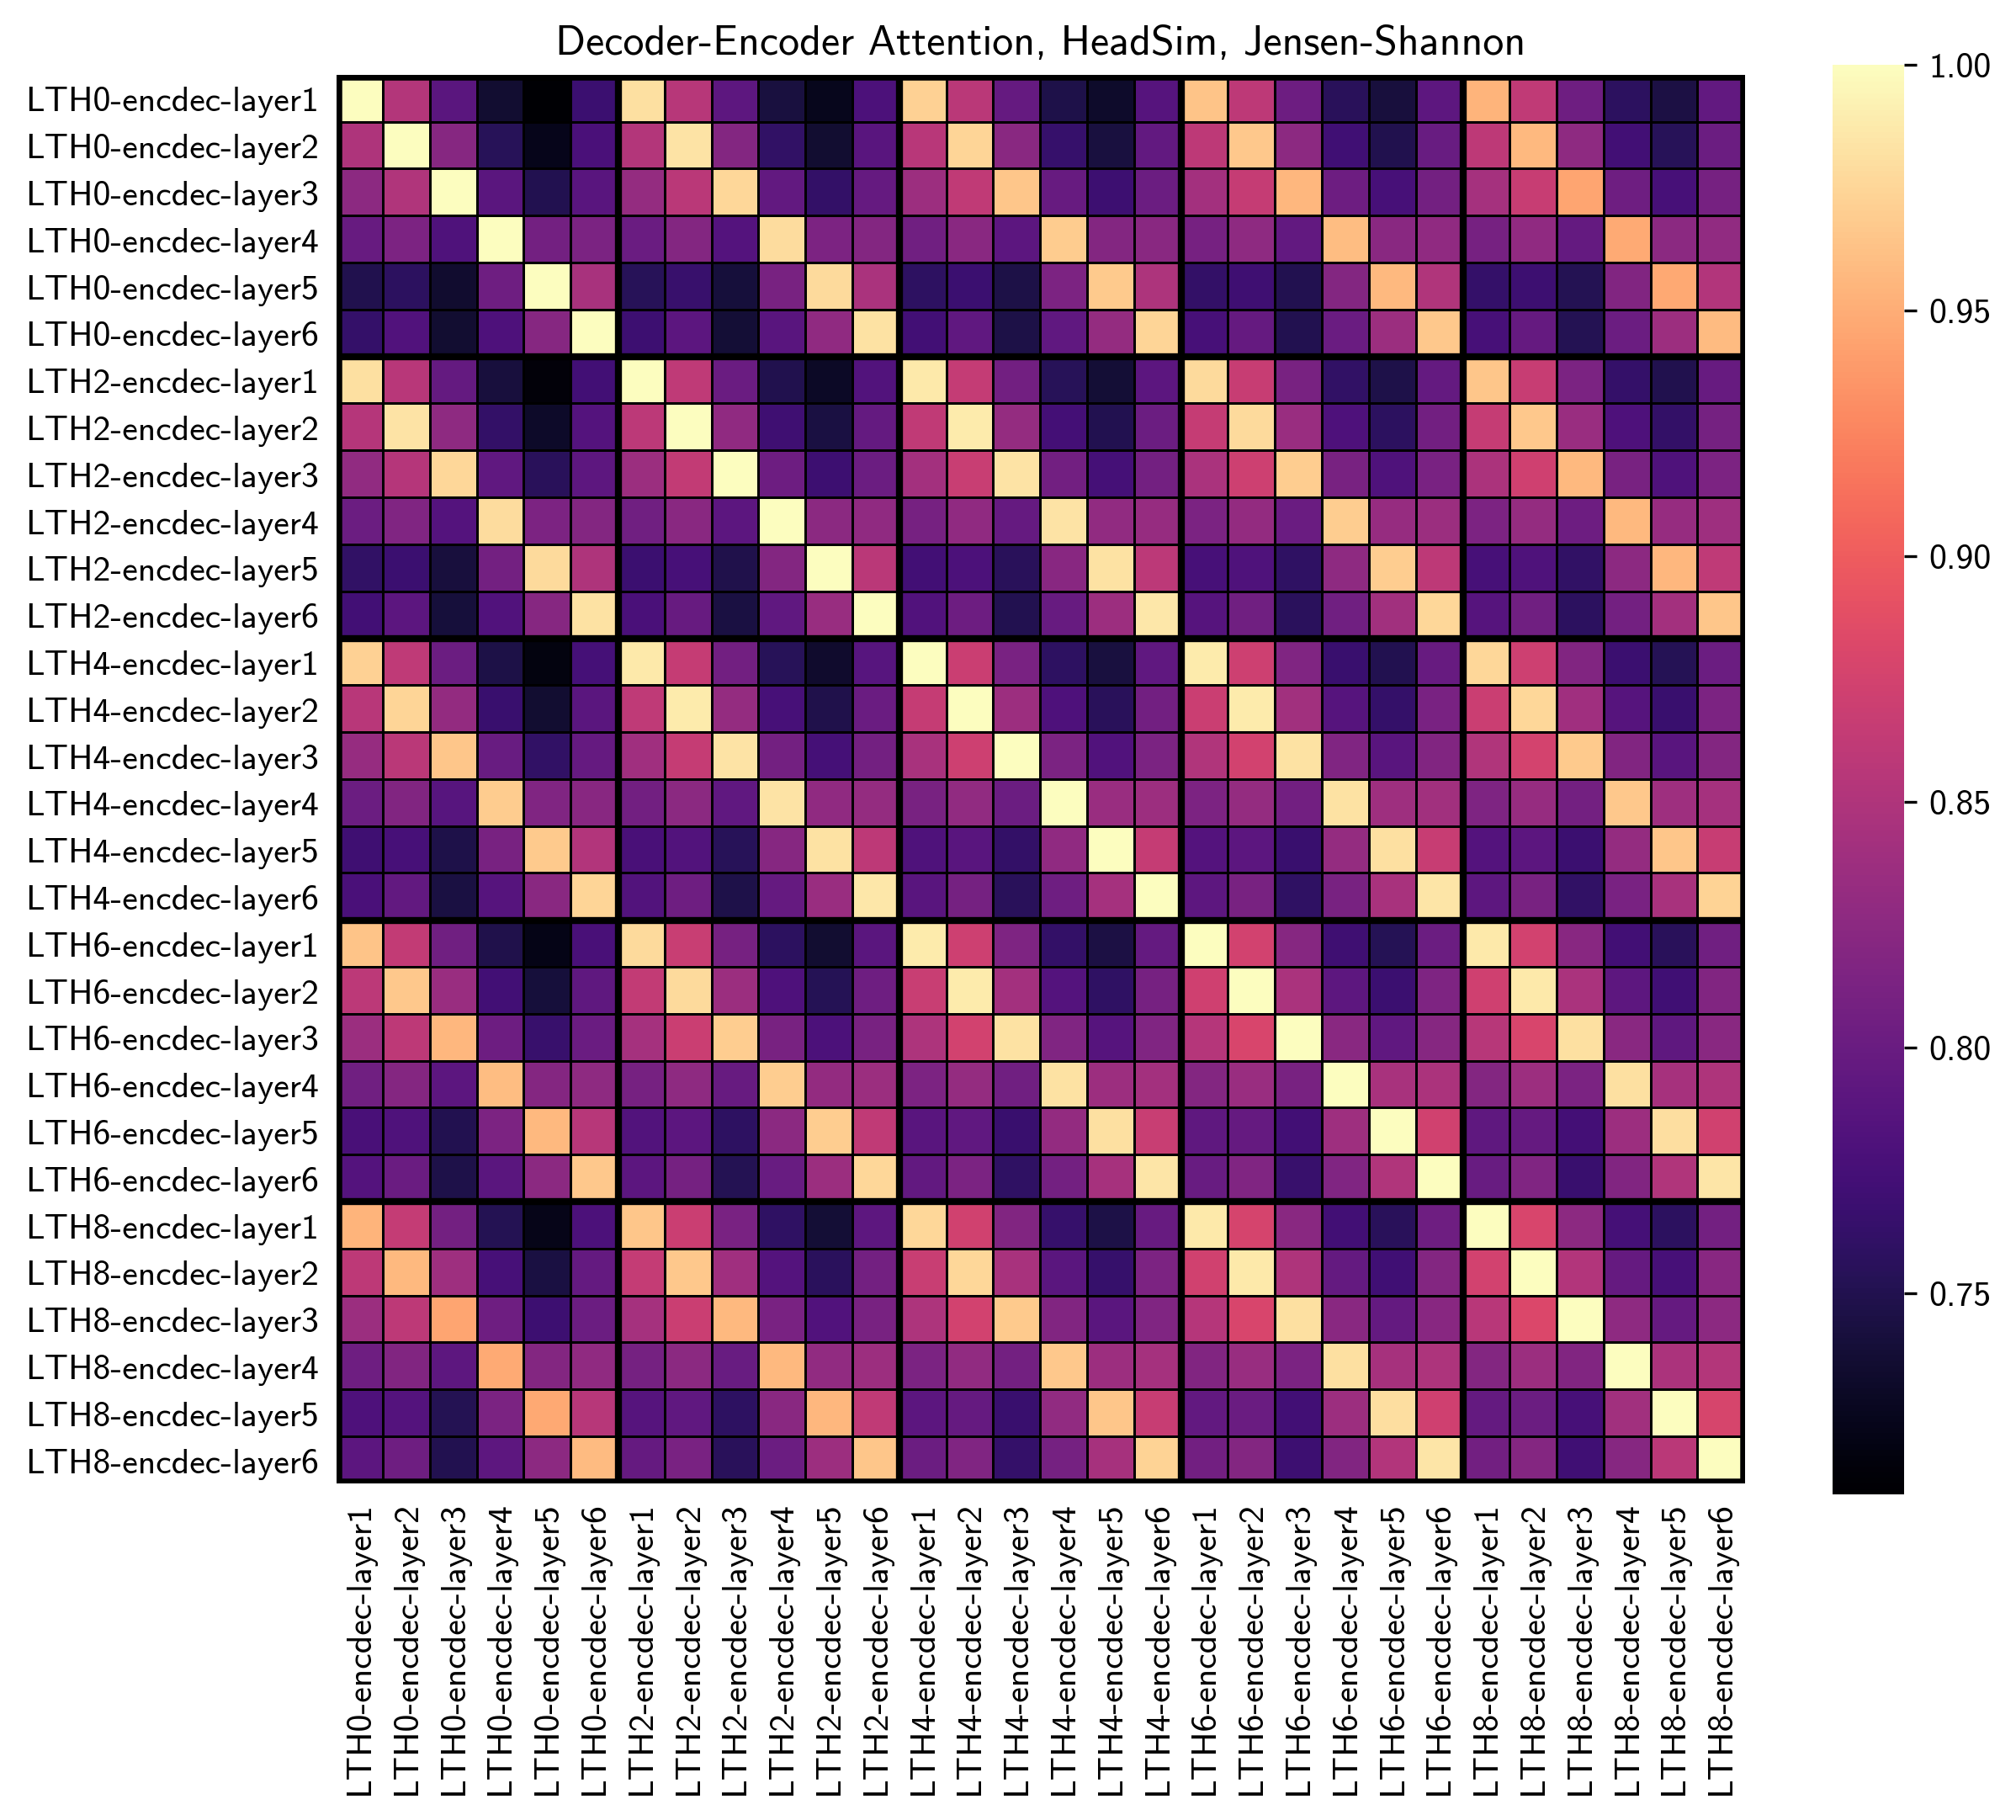

In [136]:
type_to_titles = {'encenc': 'Encoder Self-Attention', 
                  'encdec': 'Decoder-Encoder Attention',
                  'decdec': 'Decoder Self-Attention'
                 }

for attntype in attnsim:
    # jensen shannon doesn't work for enc/dec self-attn because attention maps are 'trivial', always pointing to one token only
    if attntype == 'encenc' or attntype == 'decdec':
        continue
    corr_df = pd.DataFrame(attnsim[attntype]['jsmaxcorr'])
    use_models = ['LTH0', 'LTH2', 'LTH4', 'LTH6', 'LTH8']
    use_cols = [col.split('-')[0] in use_models for col in  corr_df.columns]
    corr_df = corr_df.iloc[use_cols, use_cols]

    plt.figure(figsize = (9, 7.5), dpi=300)
    ax = sns.heatmap(corr_df, cmap='magma', lw=0.5, linecolor='k', square=True)
    ax.tick_params(axis='both', which='both', length=0, pad=5)
    for x in range(0, len(corr_df.columns)+6, 6):
        ax.axvline(x, lw=2, color='k')
        ax.axhline(x, lw=2, color='k')
    ax.add_patch(Rectangle((0, 0), len(corr_df.columns), len(corr_df.index), fill=False, edgecolor='black', lw=3))
    ax.set_title(f"{type_to_titles[attntype]}, HeadSim, Jensen-Shannon")
    plt.show()

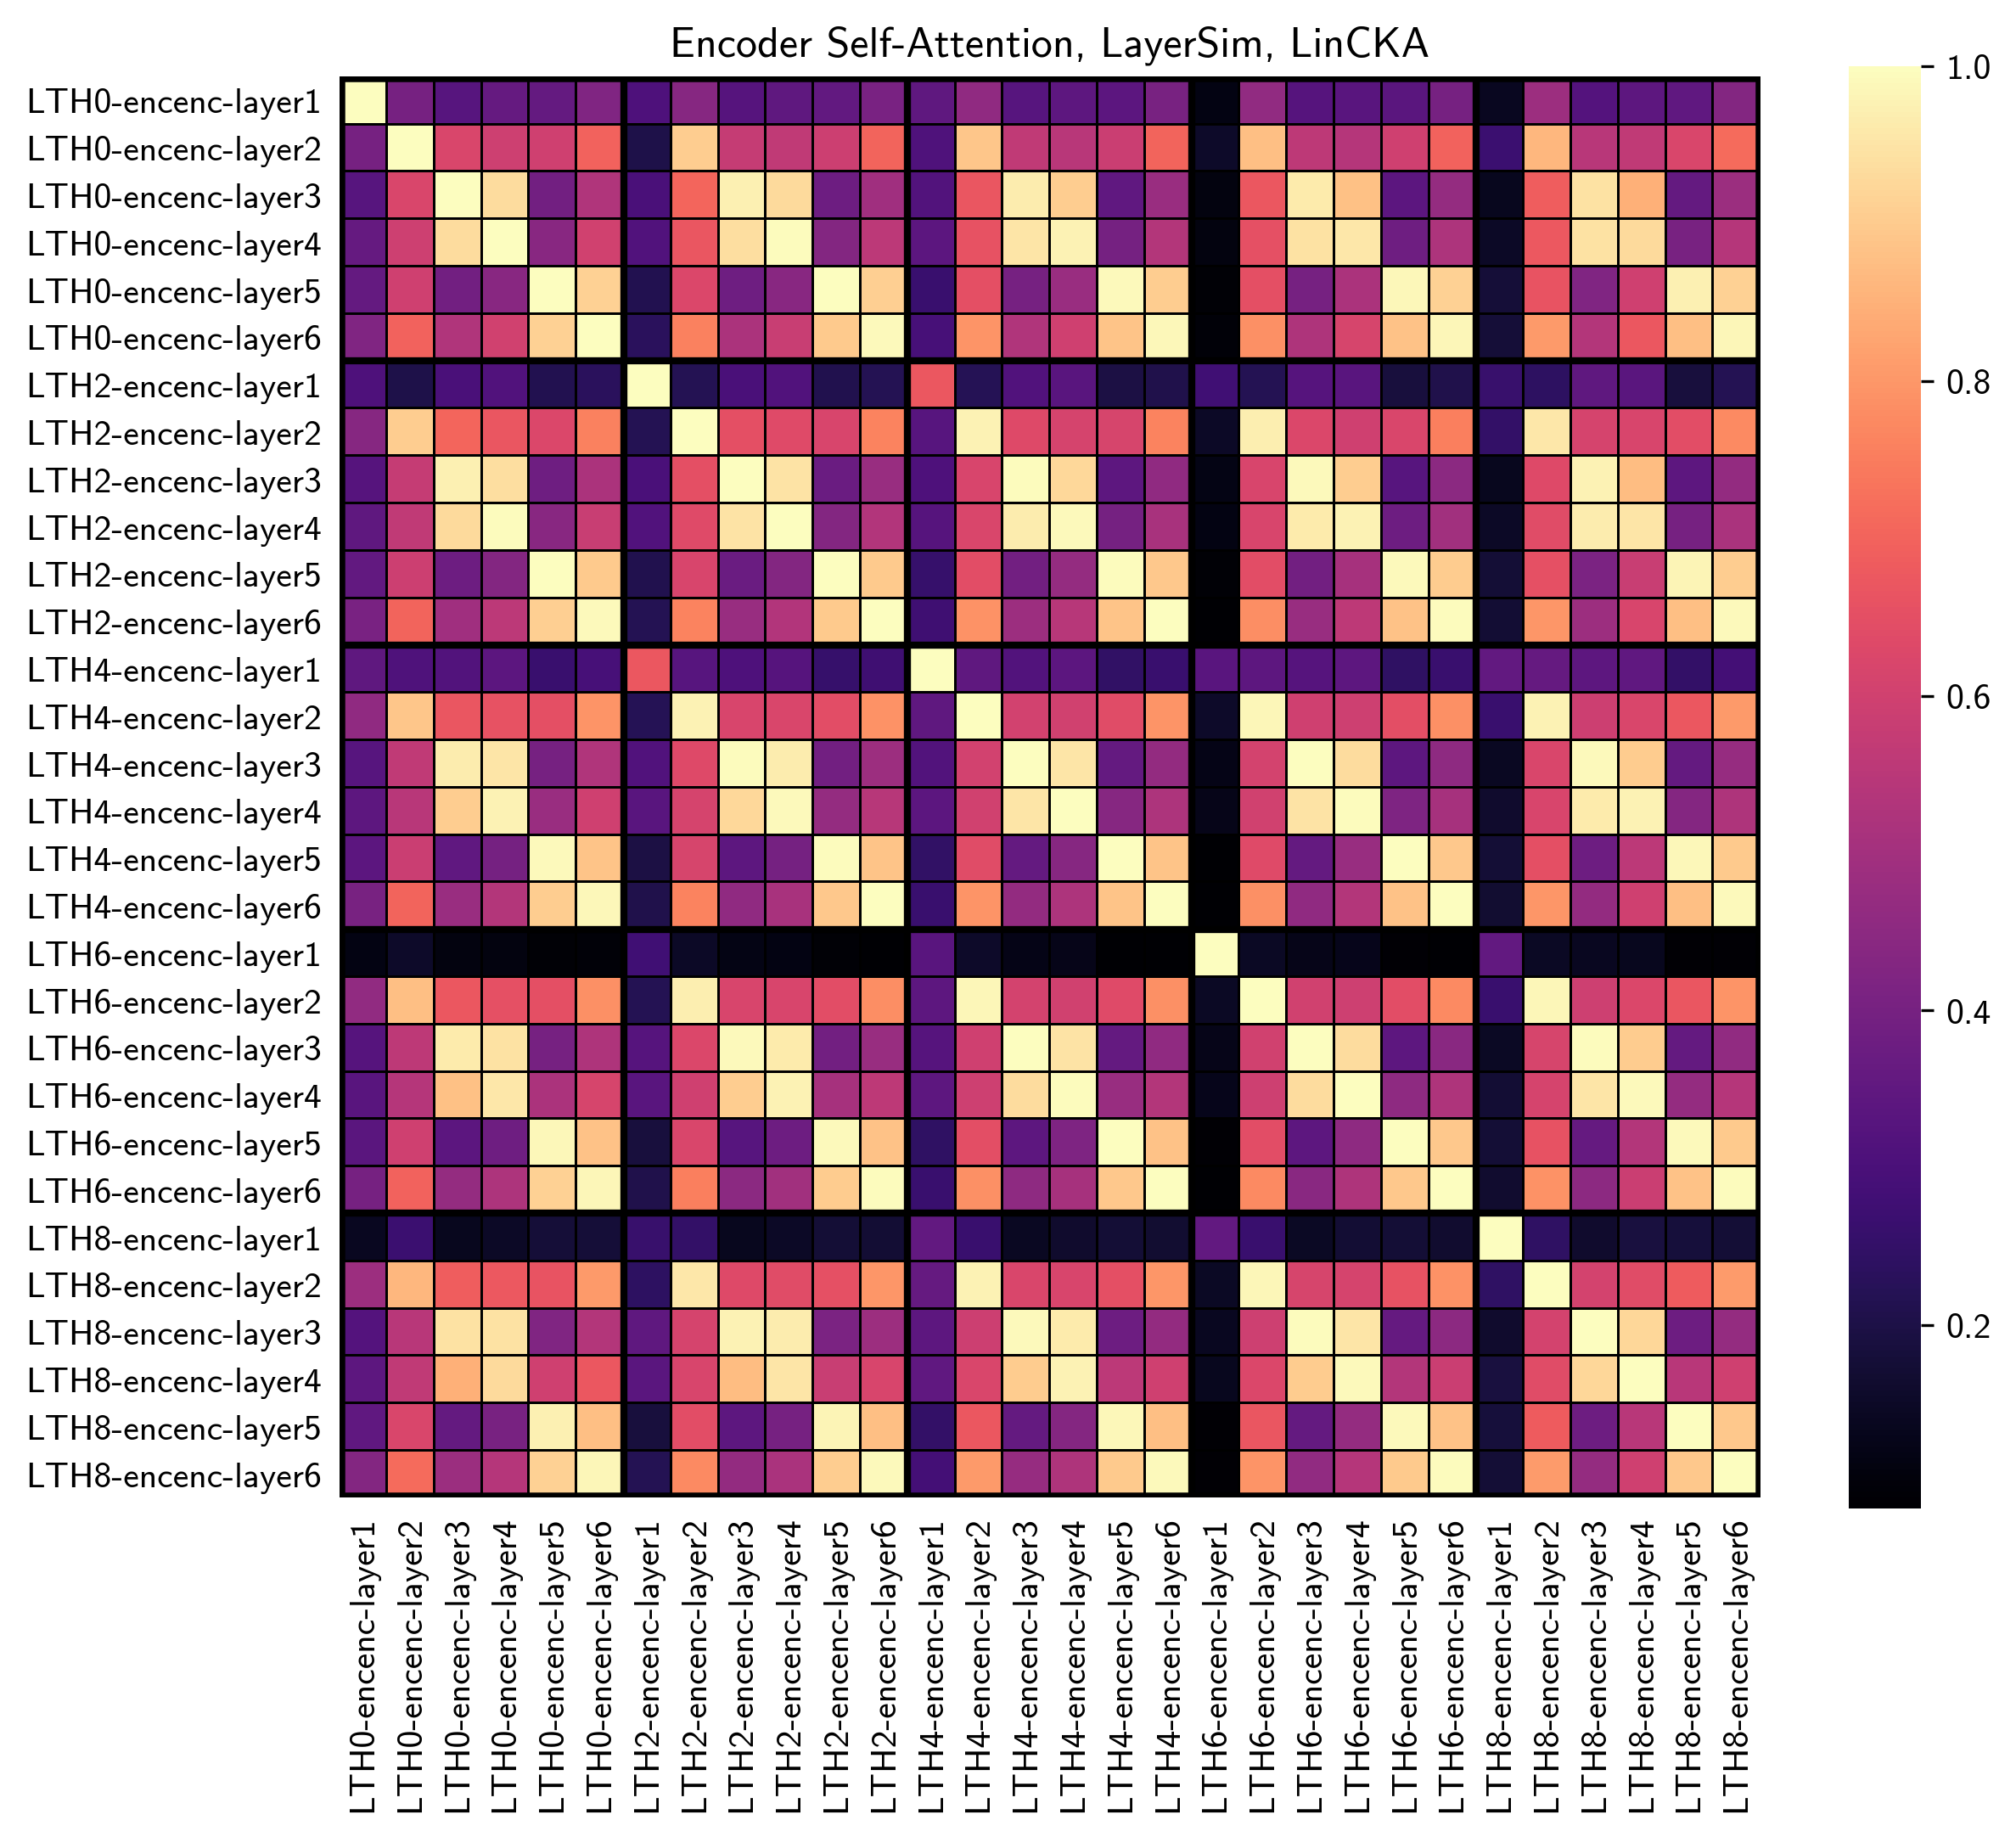

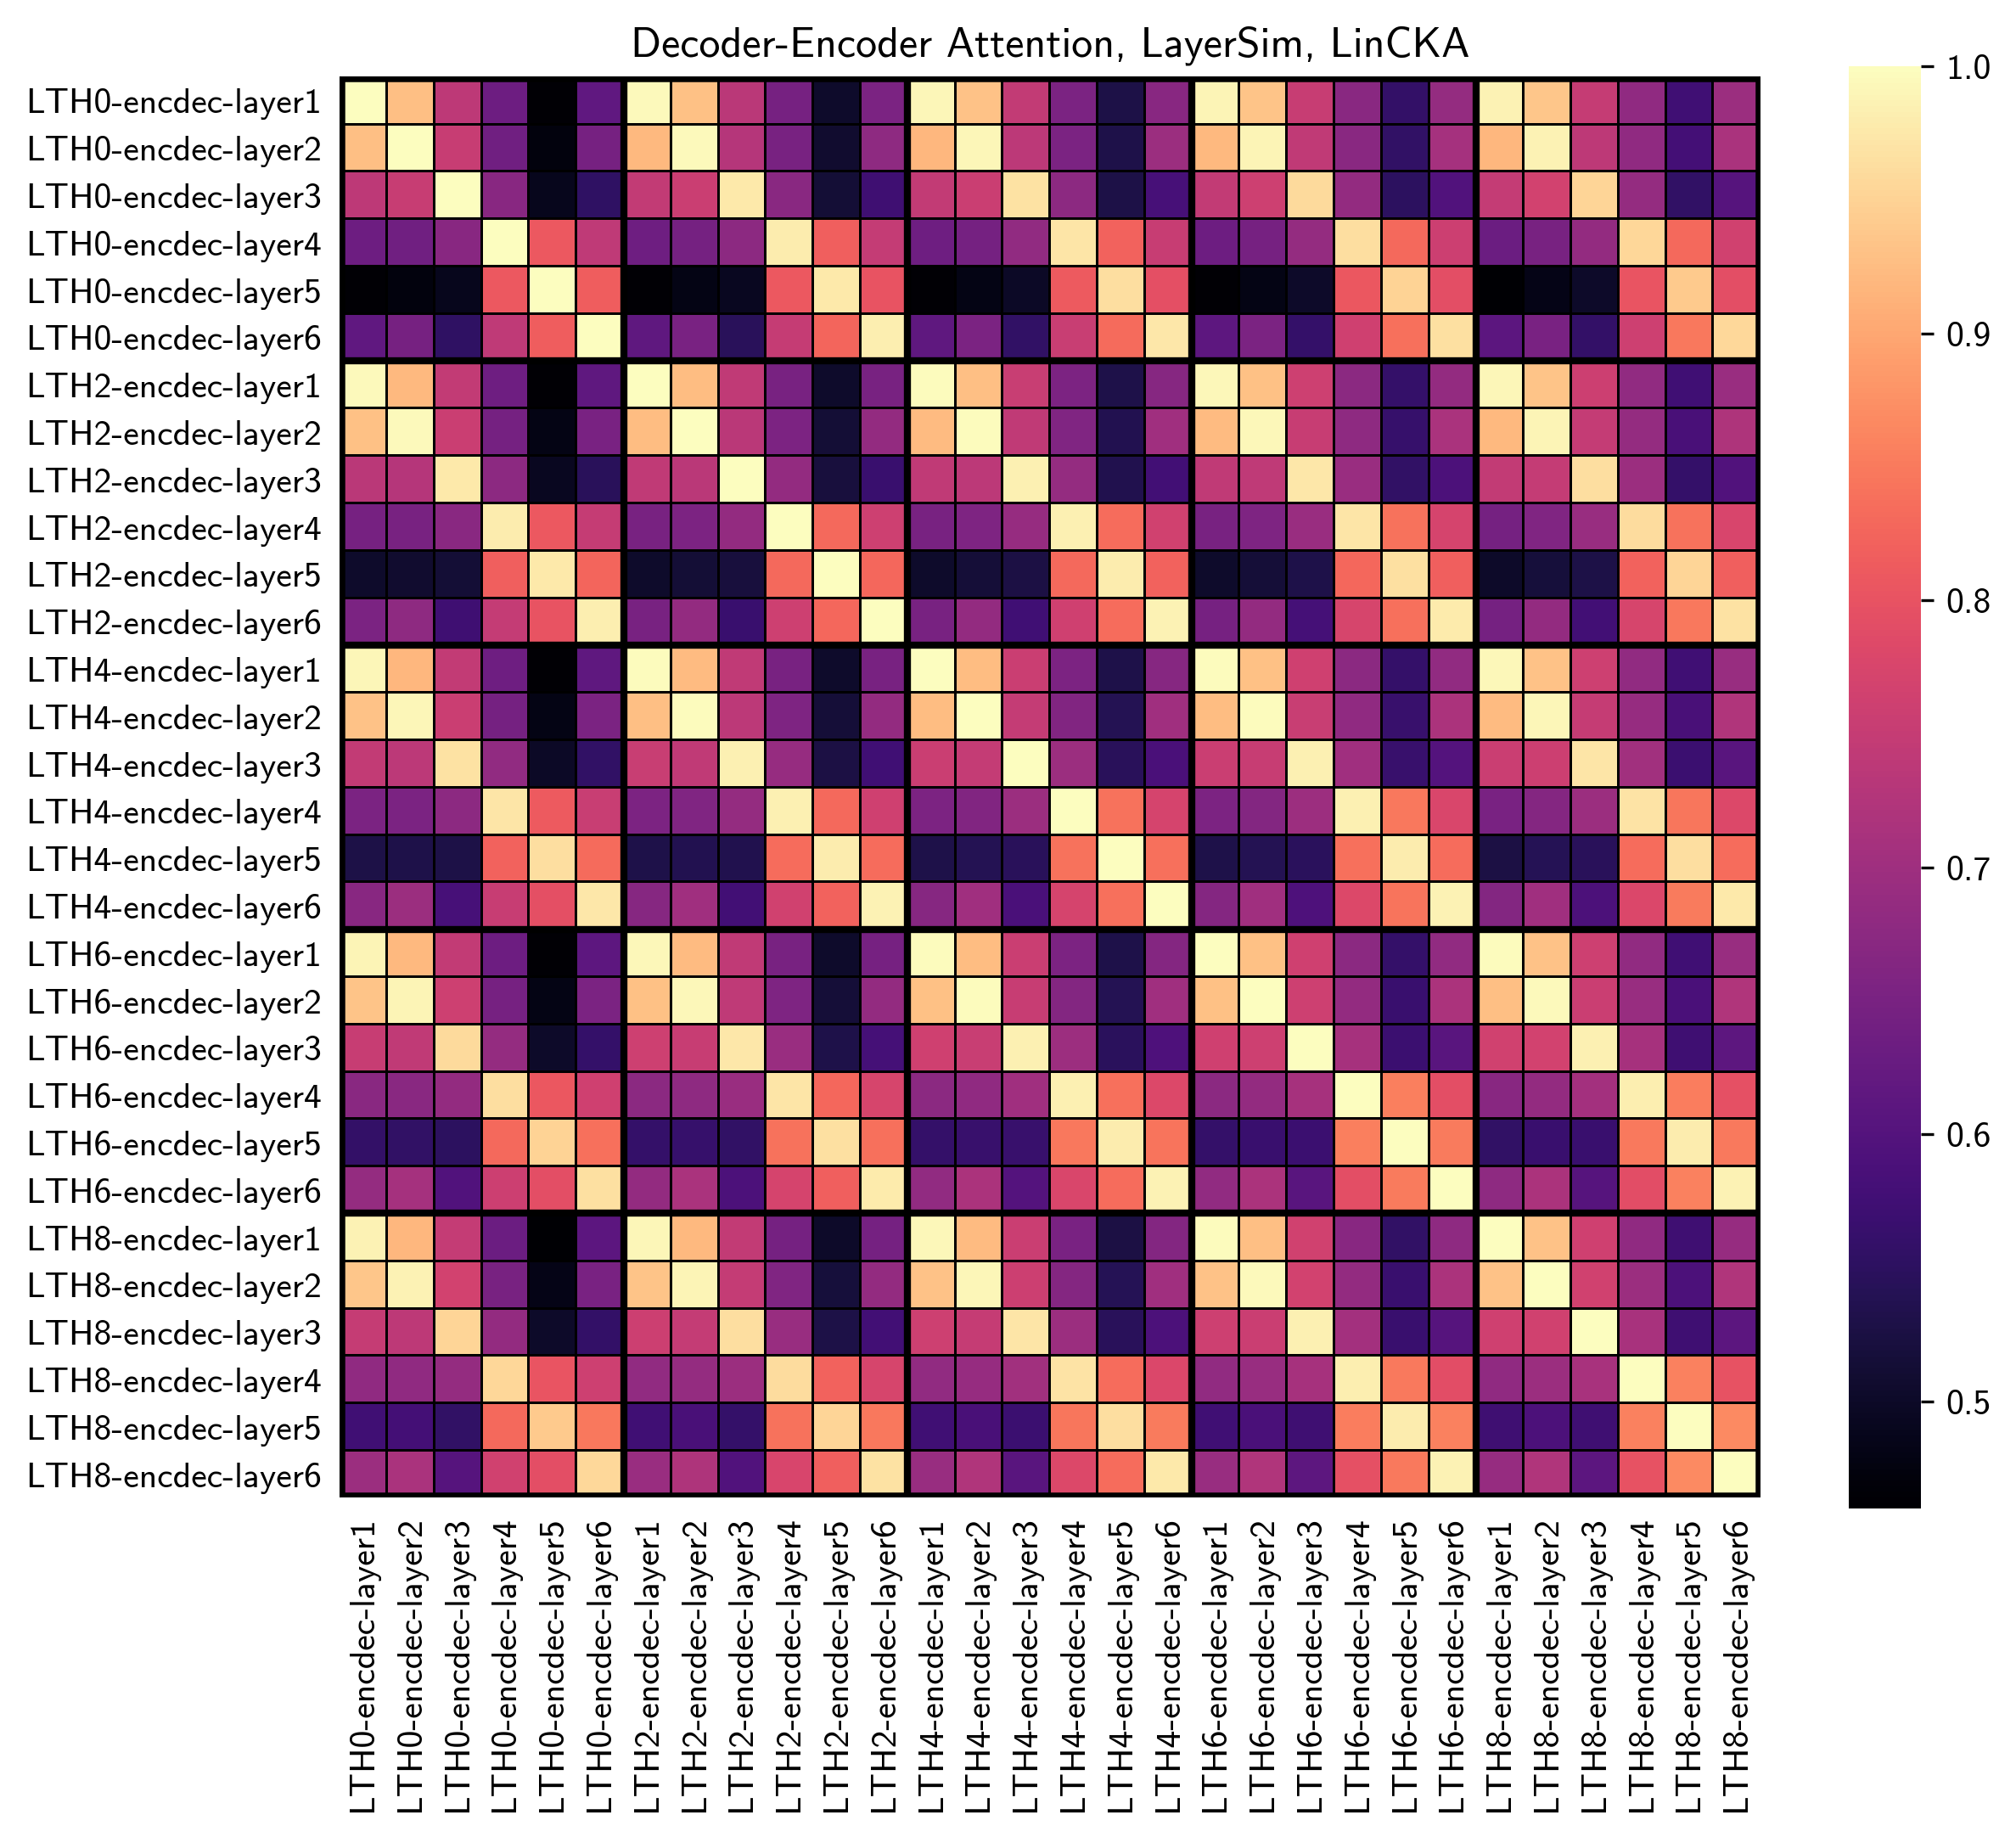

In [137]:
type_to_titles = {'encenc': 'Encoder Self-Attention', 
                  'encdec': 'Decoder-Encoder Attention',
                  'decdec': 'Decoder Self-Attention'
                 }

for attntype in attnsim:
    # for some reason lincka has an error with dec self attn
    if attntype == 'decdec':
        continue
    corr_df = pd.DataFrame(attnsim[attntype]['lincka'])
    use_models = ['LTH0', 'LTH2', 'LTH4', 'LTH6', 'LTH8']
    use_cols = [col.split('-')[0] in use_models for col in  corr_df.columns]
    corr_df = corr_df.iloc[use_cols, use_cols]

    plt.figure(figsize = (9, 7.5), dpi=300)
    ax = sns.heatmap(corr_df, cmap='magma', lw=0.5, linecolor='k', square=True)
    ax.tick_params(axis='both', which='both', length=0, pad=5)
    for x in range(0, len(corr_df.columns)+6, 6):
        ax.axvline(x, lw=2, color='k')
        ax.axhline(x, lw=2, color='k')
    ax.add_patch(Rectangle((0, 0), len(corr_df.columns), len(corr_df.index), fill=False, edgecolor='black', lw=3))
    ax.set_title(f"{type_to_titles[attntype]}, LayerSim, LinCKA")
    plt.show()

### Localization scores

In [185]:
attnsim.keys()

dict_keys(['encenc', 'encdec', 'decdec'])

In [188]:
head_corr_df = pd.DataFrame(attnsim['encdec']['pearsonmaxcorr'])
layer_corr_df = pd.DataFrame(attnsim['encdec']['lincka'])

localization_score = head_corr_df.mean() - layer_corr_df.mean()

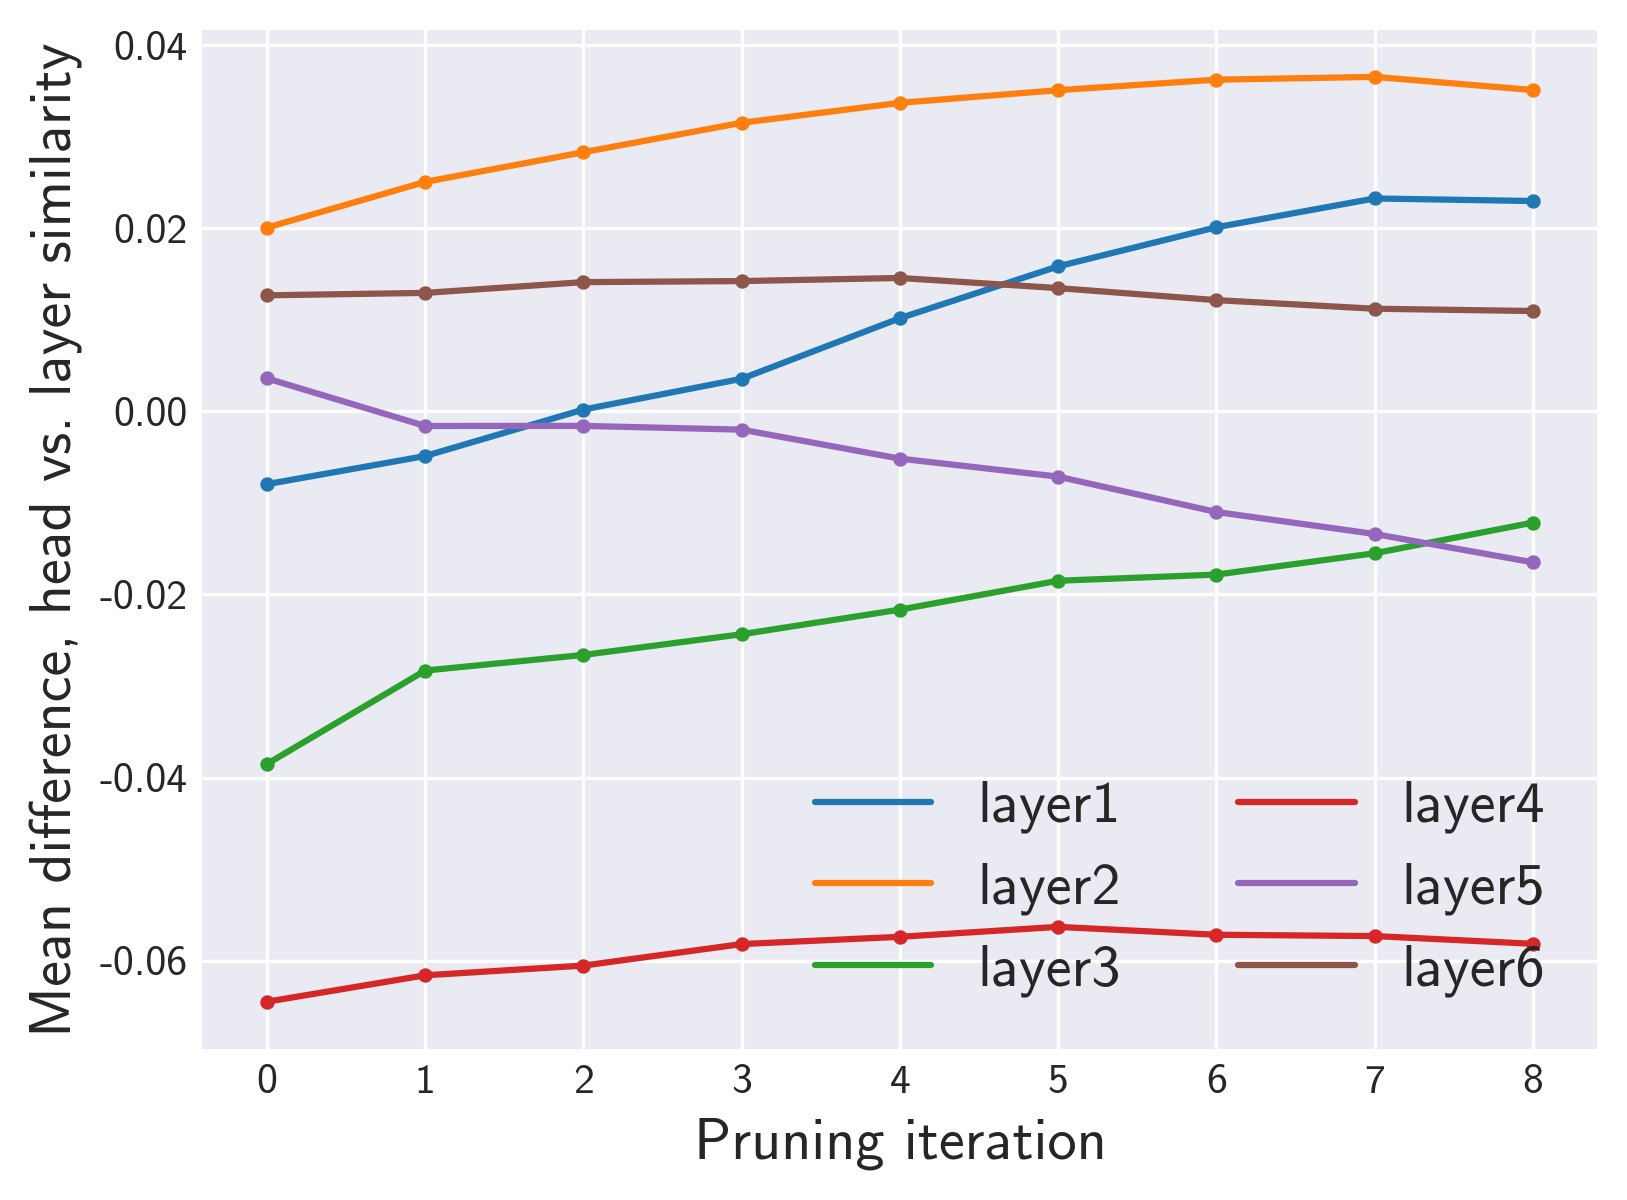

In [192]:
layer_localization_scores = {layer : [] for layer in ['layer' + str(i) for i in range(1, 7)]}
for layer in layer_localization_scores:
    for model in range(model_count):
        cur_layer = f'LTH{model}-encdec-{layer}'
        layer_localization_scores[layer].append(localization_score[cur_layer])
        
plt.figure(figsize = (6, 4.5), dpi=300)
ax = plt.gca()
x = range(model_count)

for layer in layer_localization_scores:
    ax.plot(x, layer_localization_scores[layer], label=layer)
    ax.scatter(x, layer_localization_scores[layer], s=6)
    
plt.xlabel('Pruning iteration', fontsize=14)
plt.ylabel('Mean difference, head vs. layer similarity', fontsize=14)
plt.legend(fontsize=14, ncol=2)
plt.show()

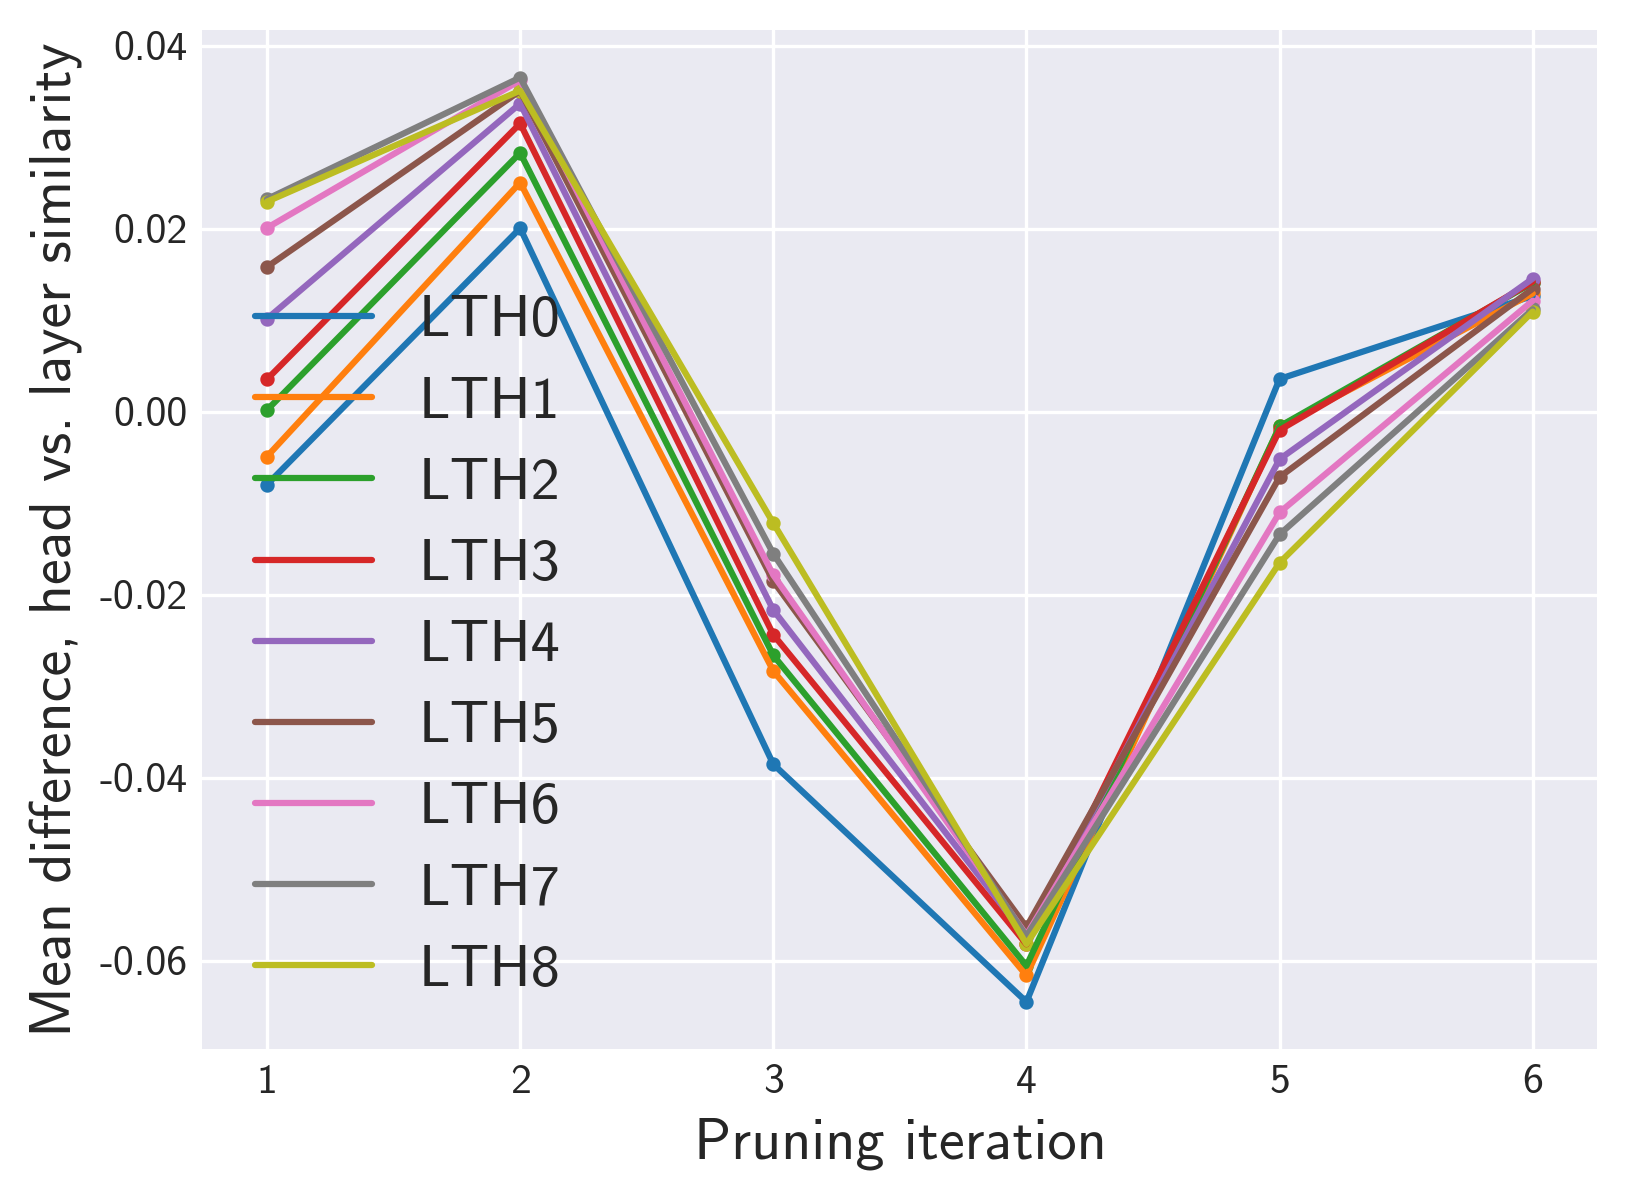

In [197]:
model_localization_scores = {model : [] for model in ['LTH' + str(i) for i in range(model_count)]}
for model in model_localization_scores:
    for layer in range(1,7):
        cur_layer = f'{model}-encdec-layer{layer}'
        model_localization_scores[model].append(localization_score[cur_layer])
        
plt.figure(figsize = (6, 4.5), dpi=300)
ax = plt.gca()
x = range(1,7)

for model in model_localization_scores:
    ax.plot(x, model_localization_scores[model], label=model)
    ax.scatter(x, model_localization_scores[model], s=6)
    
plt.xlabel('Pruning iteration', fontsize=14)
plt.ylabel('Mean difference, head vs. layer similarity', fontsize=14)
plt.legend(fontsize=14, ncol=1)
plt.show()